# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/GEANT-OD_pair.csv" # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'GRU'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'GRU_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'GRU_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time  OD_1-1       OD_1-2        OD_1-3        OD_1-4  \
0  2005-05-04-15-30     0.0  16760.79111  12407.777780  10453.848890   
1  2005-05-04-15-45     0.0  16346.46222   9373.208889   8439.048889   
2  2005-05-04-16-00     0.0  16755.22667  10638.302220  12623.520000   
3  2005-05-04-16-15     0.0  18488.00889  12263.697780  13389.128890   
4  2005-05-04-16-30     0.0  13748.27556  11323.333330  14048.426670   

        OD_1-5       OD_1-6       OD_1-7       OD_1-8       OD_1-9  ...  \
0  1468.631111  4768.444444  25290.37333  2468.515556  7984.213333  ...   
1  1032.906667  1649.520000  14433.05778  3182.986667  7243.173333  ...   
2   721.226667  1693.057778  17066.67556  5304.195556  6696.844444  ...   
3   995.600000  2984.231111  13325.22667  6248.248889  5719.804444  ...   
4   804.044444  2698.124444  16651.25333  5761.528889  5088.204444  ...   

   OD_23-14    OD_23-15     OD_23-16     OD_23-17     OD_23-18     OD_23-19  \
0       0.0  211.395556  1212.666667  1026.391111  51508.78222  1488.951111   
1       0.0  190.142222  1079.751111   529.617778  44913.43111  1410.400000   
2       0.0   51.048889  1750.631111    81.760000  47603.85778  1016.977778   
3       0.0  217.911111  3313.120000   356.000000  47023.99111  1092.017778   
4       0.0  292.071111  4479.644444   541.288889  47737.10222  1139.217778   

      OD_23-20     OD_23-21   OD_23-22  OD_23-23  
0  175293.2444  3247.164444  14.106667       0.0  
1  148162.8711  3669.173333   6.880000       0.0  
2  154312.8711  3452.320000  24.488889       0.0  
3  148199.6622  3300.613333  36.951111       0.0  
4  147601.5467  4073.137778  59.848889       0.0  

[5 rows x 530 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('15T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2005-08-02 09:30:00', freq='15T')

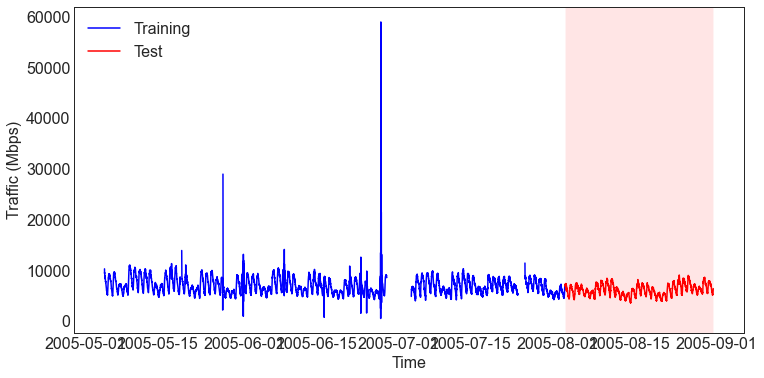

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

4.931113265982958


In [26]:
print(np.min(data.flatten()))

-0.003975552580138194


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

10769


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(10759, 10, 529)

In [32]:
y_data.shape

(10759, 1, 529)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(10759, 529)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

8606

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

6884

In [40]:
valid_length

1722

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(6884, 529, 10)

In [43]:
y_train.shape

(6884, 529)

In [44]:
X_valid.shape

(1722, 529, 10)

In [45]:
y_valid.shape

(1722, 529)

In [46]:
X_test.shape

(2153, 529, 10)

In [47]:
y_test.shape

(2153, 529)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(8606, 529, 10)

In [50]:
y.shape

(8606, 529)

In [51]:
splits

((#6884) [0,1,2,3,4,5,6,7,8,9...],
 (#1722) [6884,6885,6886,6887,6888,6889,6890,6891,6892,6893...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#8606) [(TSTensor(vars:529, len:10), tensor([0.0000e+00, 8.9423e-02, 3.7106e-01, 1.0264e-01, 7.2026e-02, 3.4304e-03,
        7.1890e-02, 1.2682e-02, 2.5281e-02, 9.1491e-03, 5.0183e-03, 1.2151e-01,
        0.0000e+00, 5.6280e-05, 1.8669e-02, 3.2046e-01, 3.0214e-02, 4.0630e-01,
        5.0114e-02, 6.6921e-02, 1.0054e-04, 0.0000e+00, 2.1455e-01, 0.0000e+00,
        7.3656e-01, 2.4451e-03, 1.4999e-02, 9.5933e-04, 1.4186e-01, 9.6139e-03,
        7.5581e-03, 5.6137e-01, 1.3439e-03, 7.8781e-03, 4.1034e-02, 1.0031e-02,
        5.2605e-03, 3.9400e-03, 5.2090e-02, 4.1799e-03, 2.3216e-02, 6.7784e-02,
        3.5897e-02, 1.7727e-01, 4.3577e-03, 5.7287e-01, 0.0000e+00, 7.6272e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0254e-04, 6.5089e-03, 1.7143e-03,
        1.1740e-01, 4.1891e-02, 7.4133e-03, 1.8199e-02, 1.3436e-02, 1.7860e-04,
        1.5109e-02, 1.5142e-02, 7.8321e-04, 1.5964e-02, 9.8029e-04, 2.2297e-02,
        8.7682e-02, 7.0101e-04, 8.7537e-03, 0.0000e+00, 2.1880e-01, 0.0000e+00,
  

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x2e8fe175c48>,
 'lr': <hyperopt.pyll.base.Apply at 0x2e8fe1759c8>,
 'epochs': <hyperopt.pyll.base.Apply at 0x2e889f4b888>,
 'patience': <hyperopt.pyll.base.Apply at 0x2e8a03223c8>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x2e8fe1cba88>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x2e8fe1cb208>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x2e8fe1cbd48>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x2e8fe166a88>}

In [55]:
# clear memory 
gc.collect()

40

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = GRU
        k = {
            'n_layers': params['n_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
  0%|                                                                          | 0/100 [00:03<?, ?trial/s, best loss=?]

No improvement since epoch 52: early stopping                                                                          
  0%|                                                                          | 0/100 [00:59<?, ?trial/s, best loss=?]

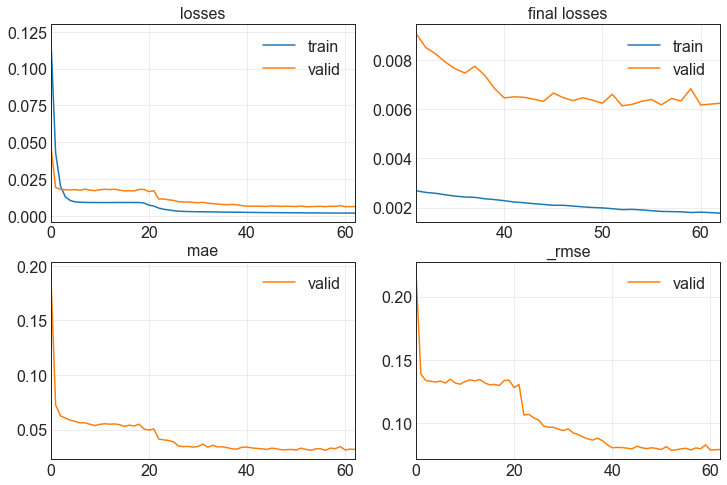

56.500083208084106                                                                                                     
[0.0017804497620090842, 0.006241198629140854, 0.03182588890194893, 0.07900125533342361]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
  1%|▍                                           | 1/100 [01:01<1:38:52, 59.93s/trial, best loss: 0.006241198629140854]

No improvement since epoch 37: early stopping                                                                          
  1%|▍                                           | 1/100 [02:45<1:38:52, 59.93s/trial, best loss: 0.006241198629140854]

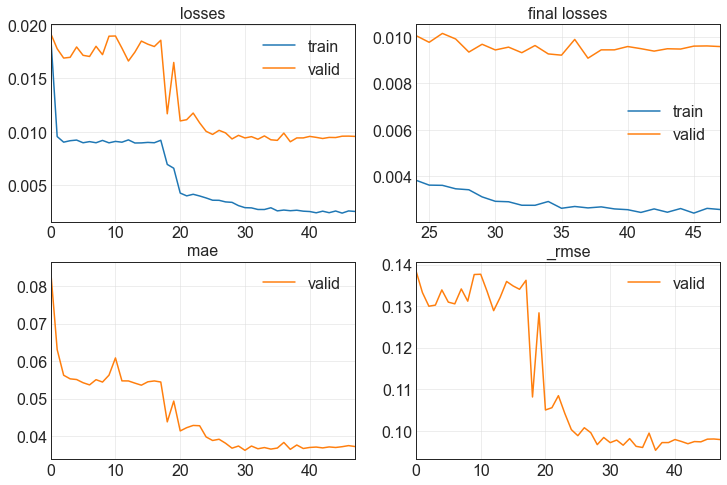

104.36444854736328                                                                                                     
[0.002573841018602252, 0.009579537436366081, 0.03719853609800339, 0.09787511825561523]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
  2%|▉                                           | 2/100 [02:47<2:00:24, 73.71s/trial, best loss: 0.006241198629140854]

No improvement since epoch 6: early stopping                                                                           
  2%|▉                                           | 2/100 [02:55<2:00:24, 73.71s/trial, best loss: 0.006241198629140854]

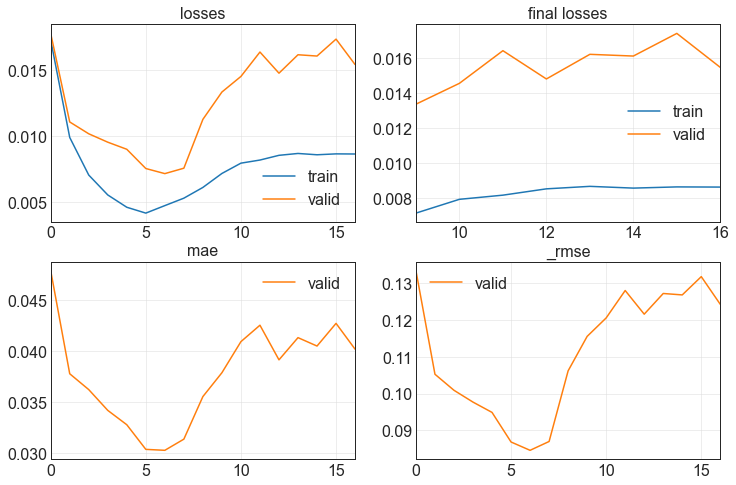

8.385351419448853                                                                                                      
[0.00863800011575222, 0.015449520200490952, 0.04020573943853378, 0.12429609149694443]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
  3%|█▎                                          | 3/100 [02:57<1:28:10, 54.54s/trial, best loss: 0.006241198629140854]

No improvement since epoch 8: early stopping                                                                           
  3%|█▎                                          | 3/100 [04:10<1:28:10, 54.54s/trial, best loss: 0.006241198629140854]

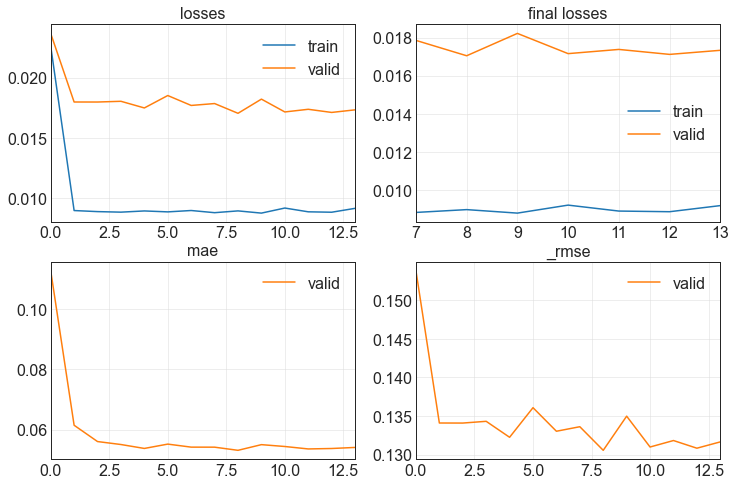

73.70212817192078                                                                                                      
[0.009174739941954613, 0.017331622540950775, 0.05411789193749428, 0.13164961338043213]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
  4%|█▊                                          | 4/100 [04:12<1:37:08, 60.72s/trial, best loss: 0.006241198629140854]

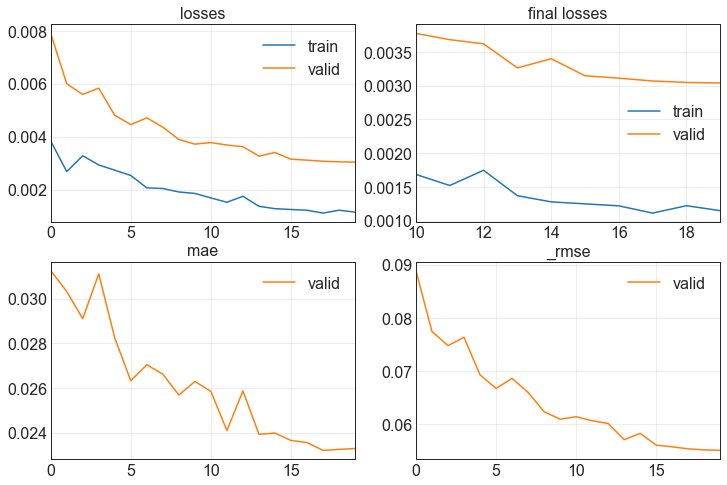

67.29269218444824                                                                                                      
[0.001145635382272303, 0.00303838262334466, 0.02328541688621044, 0.0551215223968029]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
  5%|██▎                                          | 5/100 [05:20<1:39:56, 63.12s/trial, best loss: 0.00303838262334466]

No improvement since epoch 25: early stopping                                                                          
  5%|██▎                                          | 5/100 [08:23<1:39:56, 63.12s/trial, best loss: 0.00303838262334466]

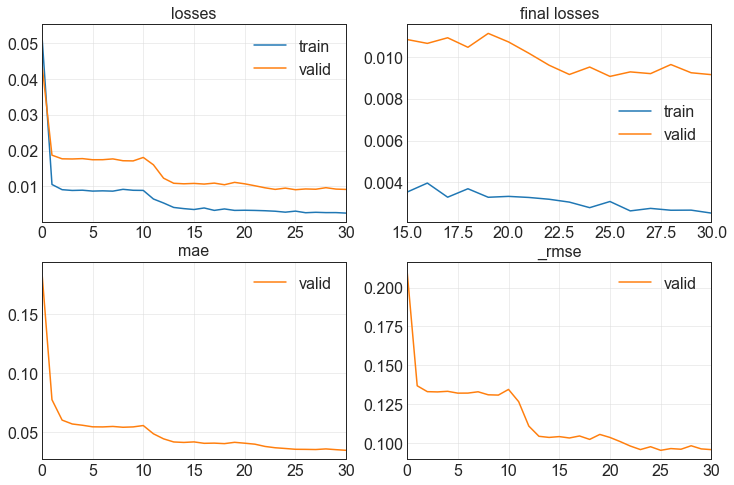

183.33261799812317                                                                                                     
[0.0025374244432896376, 0.00914640910923481, 0.03419727087020874, 0.09563685208559036]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
  6%|██▋                                          | 6/100 [08:25<2:36:01, 99.60s/trial, best loss: 0.00303838262334466]

No improvement since epoch 3: early stopping                                                                           
  6%|██▋                                          | 6/100 [09:00<2:36:01, 99.60s/trial, best loss: 0.00303838262334466]

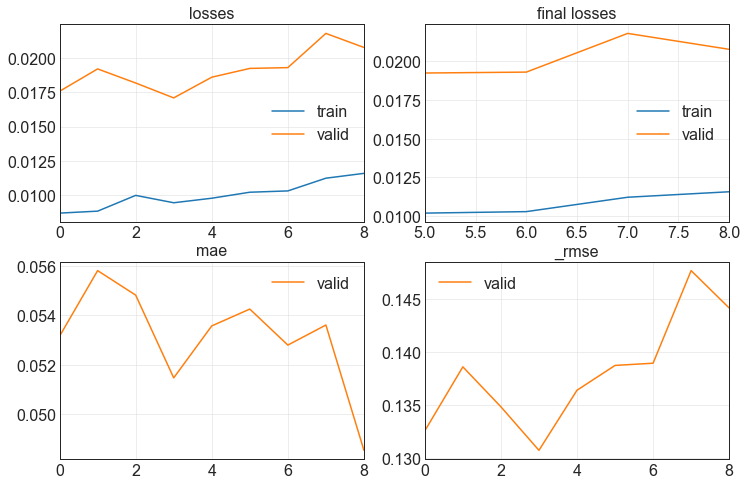

35.4979293346405                                                                                                       
[0.011578689329326153, 0.020776595920324326, 0.04853714630007744, 0.14414088428020477]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
  7%|███▏                                         | 7/100 [09:02<2:05:13, 80.79s/trial, best loss: 0.00303838262334466]

No improvement since epoch 12: early stopping                                                                          
  7%|███▏                                         | 7/100 [09:24<2:05:13, 80.79s/trial, best loss: 0.00303838262334466]

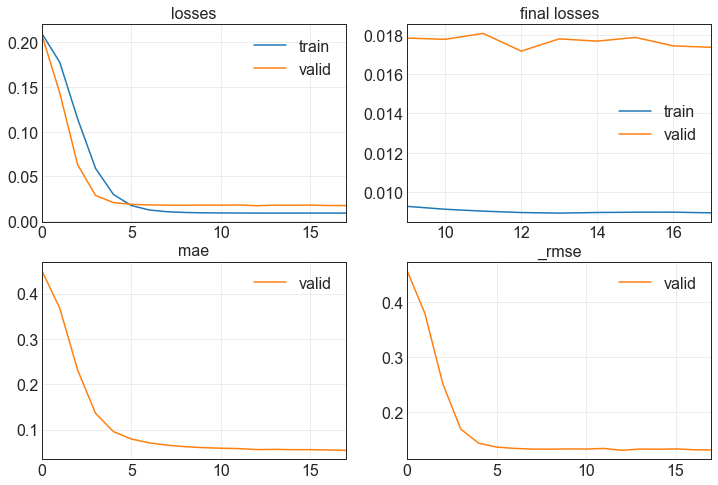

22.718398571014404                                                                                                     
[0.008939032442867756, 0.017369769513607025, 0.05435379594564438, 0.13179442286491394]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
  8%|███▌                                         | 8/100 [09:26<1:37:49, 63.79s/trial, best loss: 0.00303838262334466]

No improvement since epoch 7: early stopping                                                                           
  8%|███▌                                         | 8/100 [09:48<1:37:49, 63.79s/trial, best loss: 0.00303838262334466]

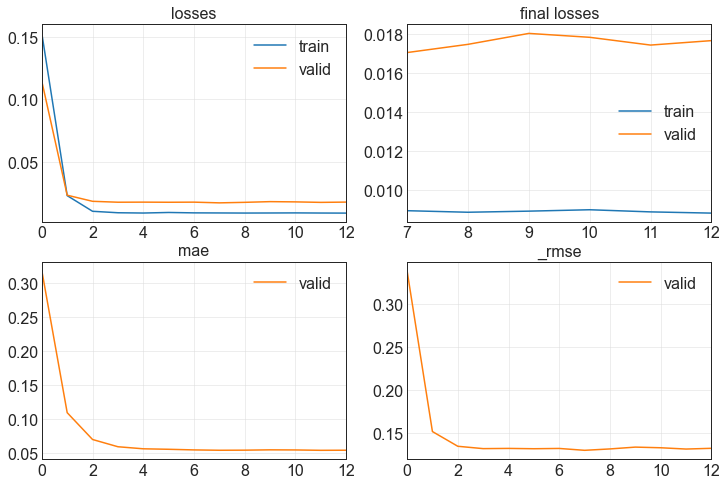

22.15008020401001                                                                                                      
[0.008816630579531193, 0.017648132517933846, 0.05462129786610603, 0.13284626603126526]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
  9%|████                                         | 9/100 [09:50<1:18:26, 51.72s/trial, best loss: 0.00303838262334466]

No improvement since epoch 27: early stopping                                                                          
  9%|████                                         | 9/100 [10:06<1:18:26, 51.72s/trial, best loss: 0.00303838262334466]

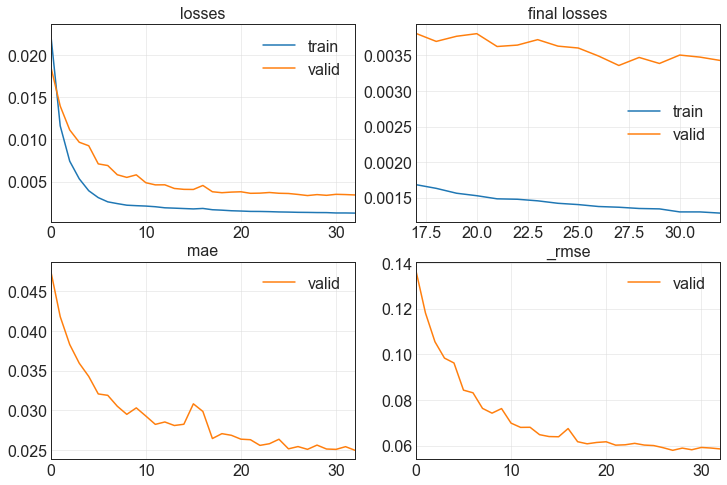

16.48195242881775                                                                                                      
[0.0012824980076402426, 0.0034293318167328835, 0.024997102096676826, 0.05856049433350563]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 10%|████▍                                       | 10/100 [10:08<1:02:21, 41.57s/trial, best loss: 0.00303838262334466]

No improvement since epoch 50: early stopping                                                                          
 10%|████▍                                       | 10/100 [10:52<1:02:21, 41.57s/trial, best loss: 0.00303838262334466]

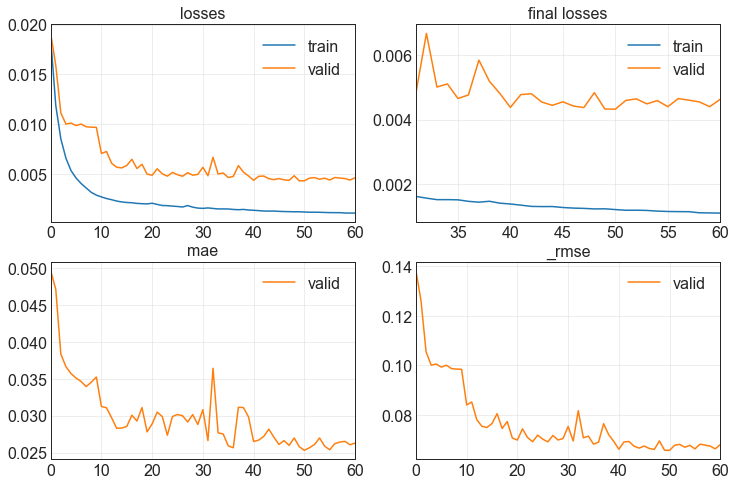

44.67341876029968                                                                                                      
[0.0010862908093258739, 0.004632291384041309, 0.026281138882040977, 0.06806093454360962]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 11%|████▊                                       | 11/100 [10:54<1:03:39, 42.92s/trial, best loss: 0.00303838262334466]

No improvement since epoch 14: early stopping                                                                          
 11%|████▊                                       | 11/100 [11:15<1:03:39, 42.92s/trial, best loss: 0.00303838262334466]

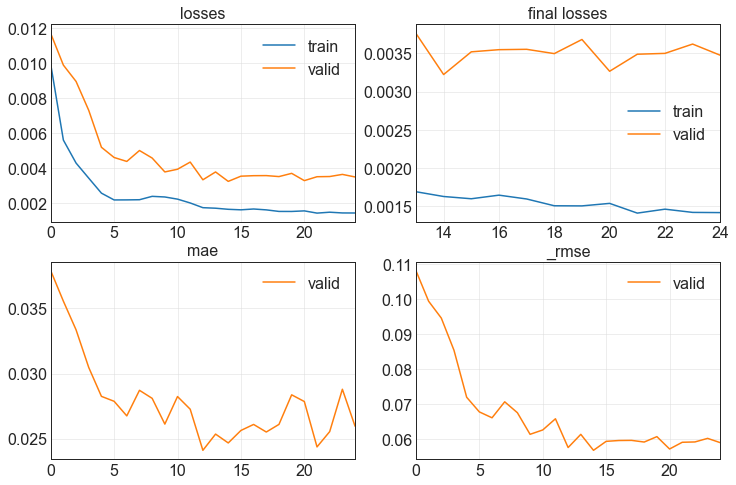

22.084304094314575                                                                                                     
[0.0014152313815429807, 0.003476376412436366, 0.025950390845537186, 0.05896080657839775]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 12%|█████▌                                        | 12/100 [11:17<54:23, 37.09s/trial, best loss: 0.00303838262334466]

No improvement since epoch 39: early stopping                                                                          
 12%|█████▌                                        | 12/100 [15:24<54:23, 37.09s/trial, best loss: 0.00303838262334466]

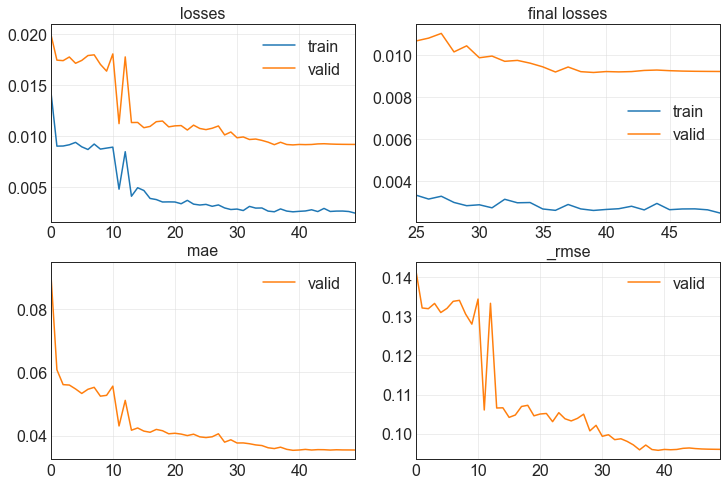

247.85385131835938                                                                                                     
[0.002469639526680112, 0.009205898270010948, 0.03546048328280449, 0.09594735503196716]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 13%|█████▌                                     | 13/100 [15:26<2:26:04, 100.74s/trial, best loss: 0.00303838262334466]

No improvement since epoch 7: early stopping                                                                           
 13%|█████▌                                     | 13/100 [15:37<2:26:04, 100.74s/trial, best loss: 0.00303838262334466]

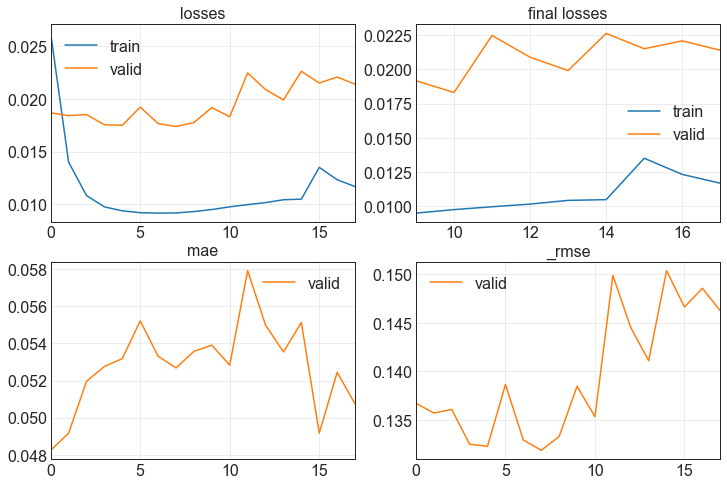

11.05225658416748                                                                                                      
[0.01168858166784048, 0.021390972658991814, 0.050745297223329544, 0.14625653624534607]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 14%|██████▏                                     | 14/100 [15:39<1:46:25, 74.25s/trial, best loss: 0.00303838262334466]

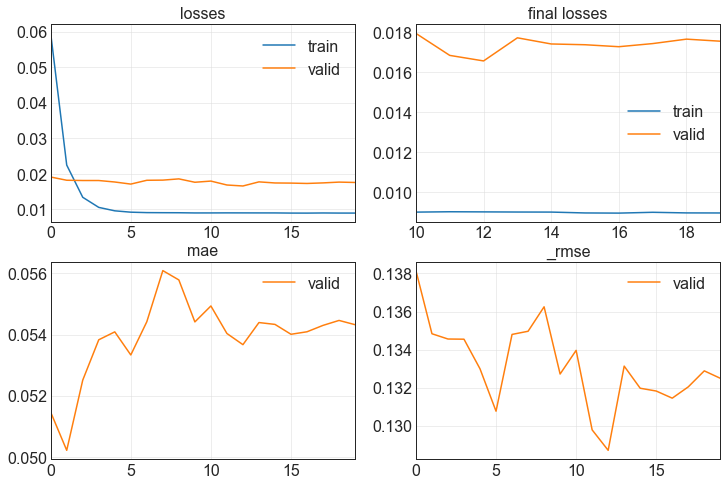

25.284364938735962                                                                                                     
[0.00894237868487835, 0.017553800716996193, 0.05432456359267235, 0.13249075412750244]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 15%|██████▌                                     | 15/100 [16:05<1:24:58, 59.99s/trial, best loss: 0.00303838262334466]

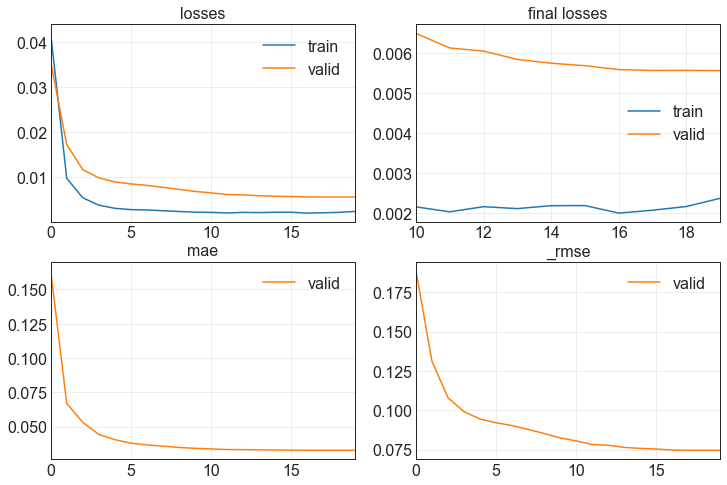

60.06935214996338                                                                                                      
[0.002372646238654852, 0.005567633081227541, 0.032724540680646896, 0.07461657375097275]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 16%|███████                                     | 16/100 [17:07<1:24:35, 60.43s/trial, best loss: 0.00303838262334466]

No improvement since epoch 9: early stopping                                                                           
 16%|███████                                     | 16/100 [17:27<1:24:35, 60.43s/trial, best loss: 0.00303838262334466]

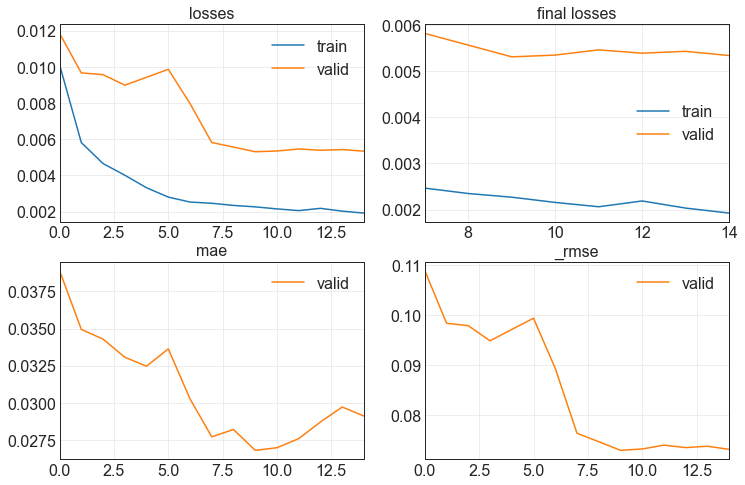

20.763356924057007                                                                                                     
[0.0019232286140322685, 0.005340981762856245, 0.02911132574081421, 0.07308202236890793]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 17%|███████▍                                    | 17/100 [17:29<1:07:43, 48.96s/trial, best loss: 0.00303838262334466]

No improvement since epoch 20: early stopping                                                                          
 17%|███████▍                                    | 17/100 [18:29<1:07:43, 48.96s/trial, best loss: 0.00303838262334466]

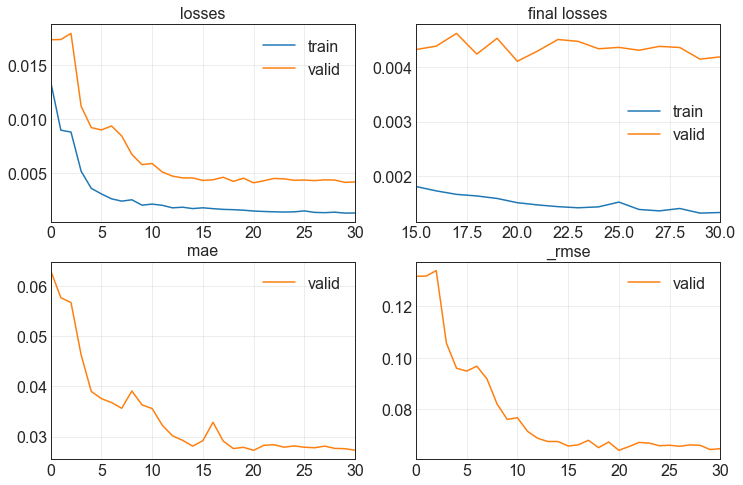

60.636680603027344                                                                                                     
[0.001325150951743126, 0.004195584449917078, 0.027302931994199753, 0.06477333605289459]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 18%|███████▉                                    | 18/100 [18:31<1:12:15, 52.88s/trial, best loss: 0.00303838262334466]

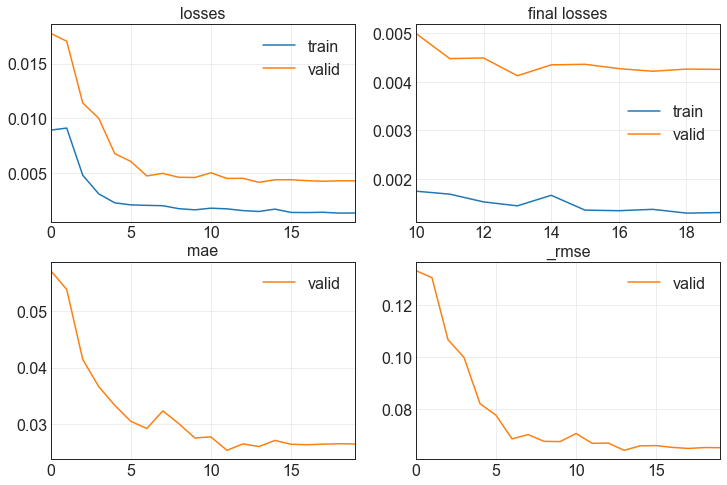

64.9986834526062                                                                                                       
[0.0013068736298009753, 0.004254835192114115, 0.026445796713232994, 0.06522910296916962]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 19%|████████▎                                   | 19/100 [19:38<1:16:51, 56.94s/trial, best loss: 0.00303838262334466]

No improvement since epoch 21: early stopping                                                                          
 19%|████████▎                                   | 19/100 [21:42<1:16:51, 56.94s/trial, best loss: 0.00303838262334466]

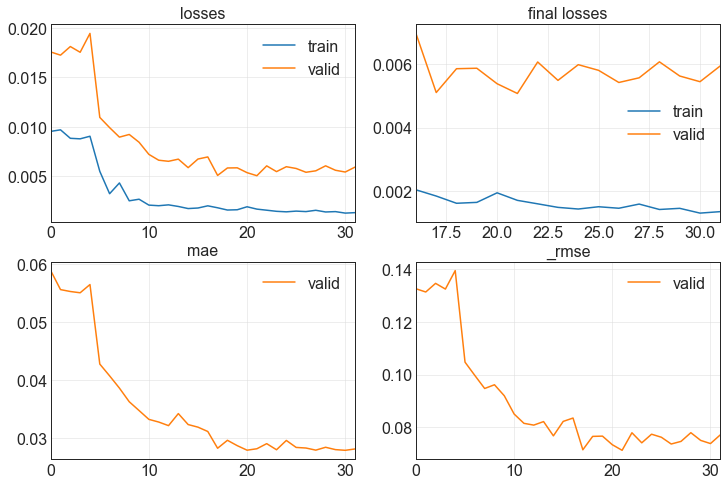

125.12322187423706                                                                                                     
[0.0013512932928279042, 0.005950051825493574, 0.028163017705082893, 0.0771365836262703]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 20%|████████▊                                   | 20/100 [21:44<1:43:44, 77.81s/trial, best loss: 0.00303838262334466]

No improvement since epoch 1: early stopping                                                                           
 20%|████████▊                                   | 20/100 [21:51<1:43:44, 77.81s/trial, best loss: 0.00303838262334466]

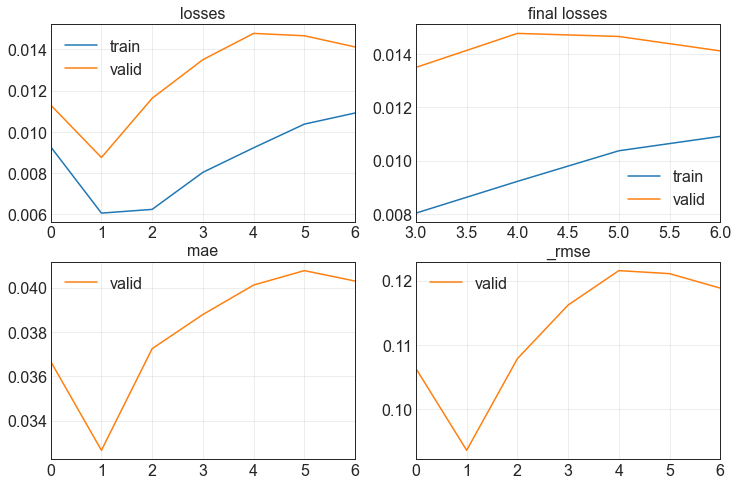

7.33118200302124                                                                                                       
[0.010911038145422935, 0.014122060500085354, 0.040298912674188614, 0.11883626878261566]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 21%|█████████▏                                  | 21/100 [21:53<1:15:10, 57.09s/trial, best loss: 0.00303838262334466]

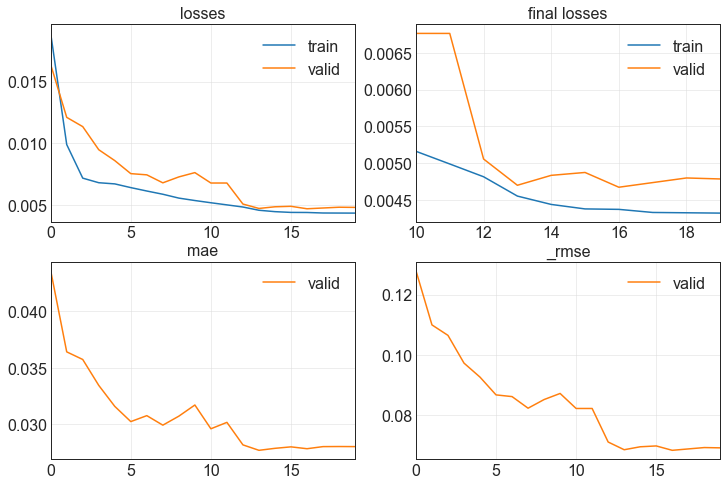

11.11414122581482                                                                                                      
[0.004321068059653044, 0.004785055294632912, 0.028026722371578217, 0.06917409598827362]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 22%|██████████                                    | 22/100 [22:05<56:49, 43.72s/trial, best loss: 0.00303838262334466]

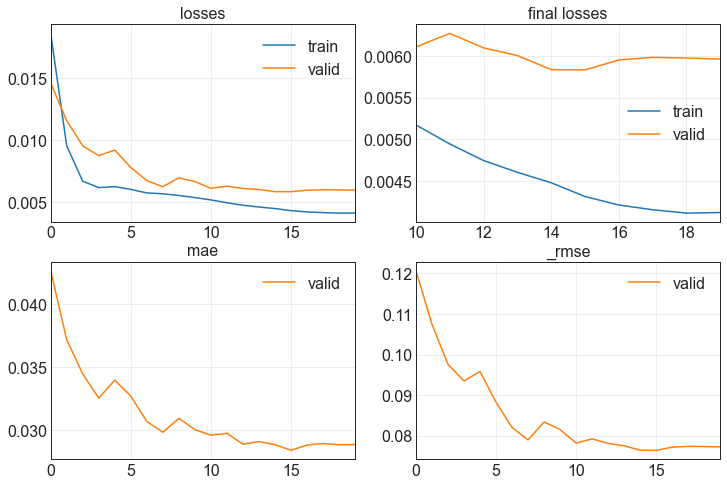

11.152270078659058                                                                                                     
[0.004117922391742468, 0.005964206997305155, 0.02883470244705677, 0.07722827047109604]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 23%|██████████▌                                   | 23/100 [22:18<44:05, 34.36s/trial, best loss: 0.00303838262334466]

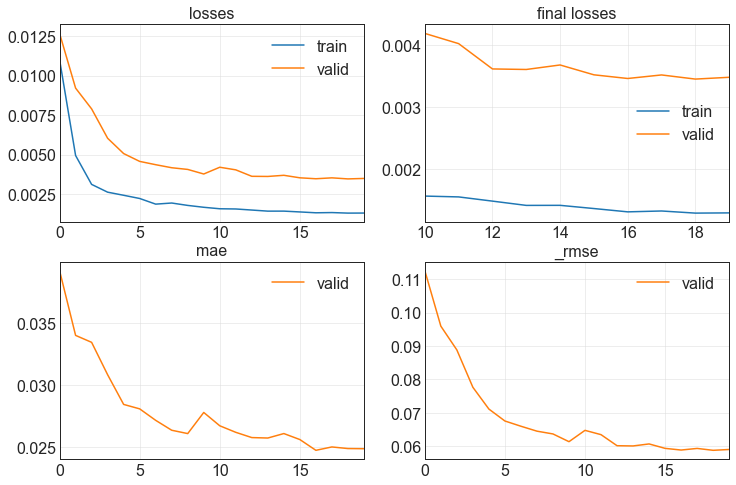

17.62729811668396                                                                                                      
[0.0012951858807355165, 0.0034857718273997307, 0.02487057074904442, 0.05904042720794678]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 24%|███████████                                   | 24/100 [22:37<37:41, 29.76s/trial, best loss: 0.00303838262334466]

No improvement since epoch 20: early stopping                                                                          
 24%|███████████                                   | 24/100 [23:23<37:41, 29.76s/trial, best loss: 0.00303838262334466]

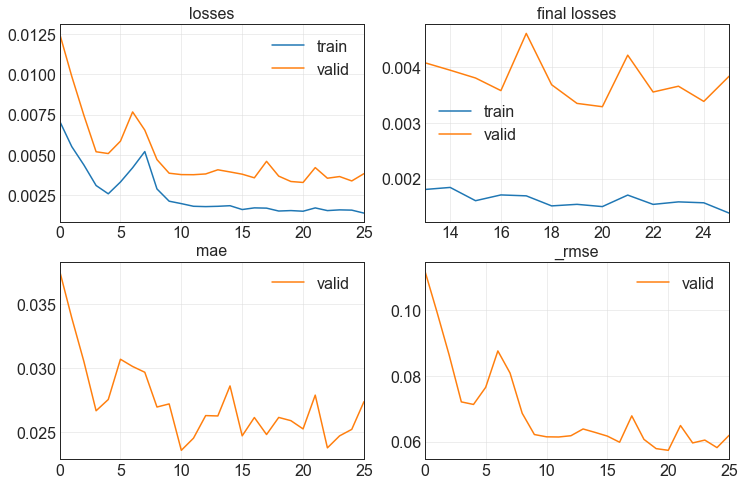

46.2635862827301                                                                                                       
[0.001384662464261055, 0.0038321008905768394, 0.027364492416381836, 0.06190396845340729]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 25%|███████████▌                                  | 25/100 [23:25<43:54, 35.13s/trial, best loss: 0.00303838262334466]

No improvement since epoch 13: early stopping                                                                          
 25%|███████████▌                                  | 25/100 [24:36<43:54, 35.13s/trial, best loss: 0.00303838262334466]

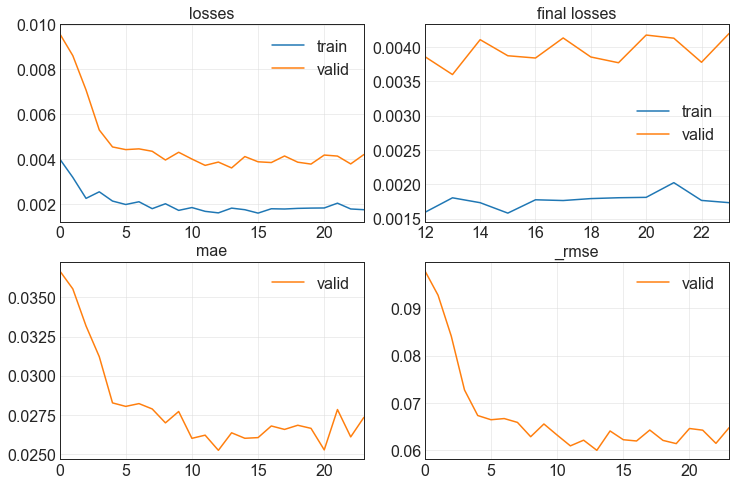

71.608234167099                                                                                                        
[0.0017331814160570502, 0.0041973101906478405, 0.0273442305624485, 0.0647866502404213]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 26%|███████████▉                                  | 26/100 [24:38<57:20, 46.49s/trial, best loss: 0.00303838262334466]

No improvement since epoch 1: early stopping                                                                           
 26%|███████████▉                                  | 26/100 [24:49<57:20, 46.49s/trial, best loss: 0.00303838262334466]

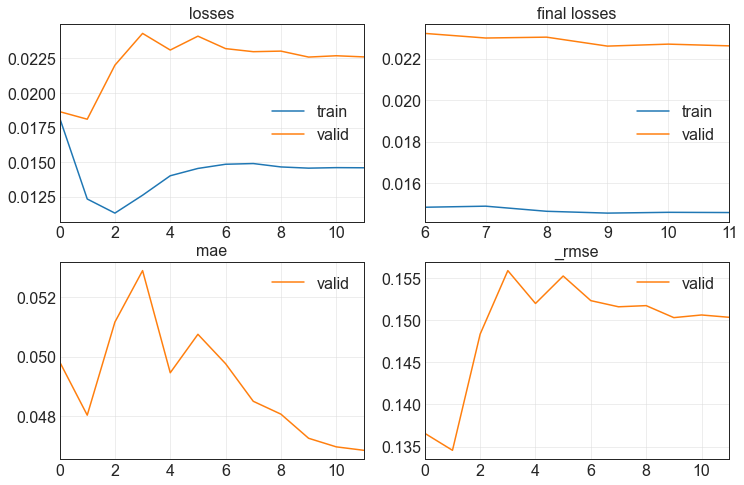

11.587751626968384                                                                                                     
[0.014590724371373653, 0.022608719766139984, 0.046851519495248795, 0.15036197006702423]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 27%|████████████▍                                 | 27/100 [24:51<44:22, 36.47s/trial, best loss: 0.00303838262334466]

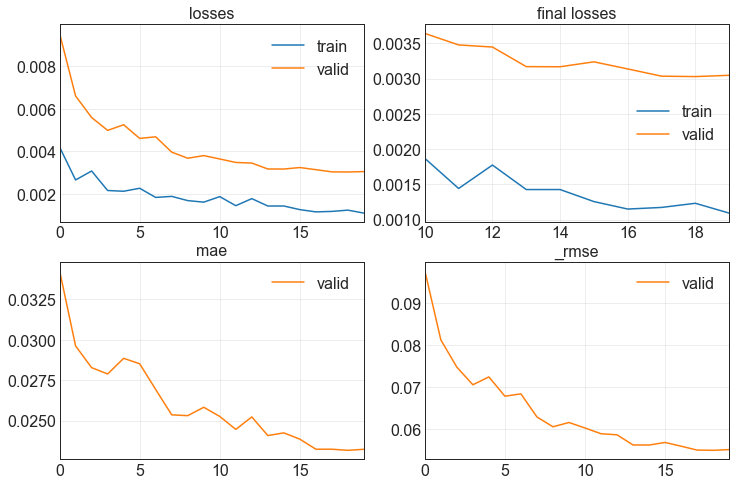

66.91937756538391                                                                                                      
[0.0010931738652288914, 0.003045756369829178, 0.023226166144013405, 0.0551883764564991]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 28%|████████████▉                                 | 28/100 [25:59<55:14, 46.04s/trial, best loss: 0.00303838262334466]

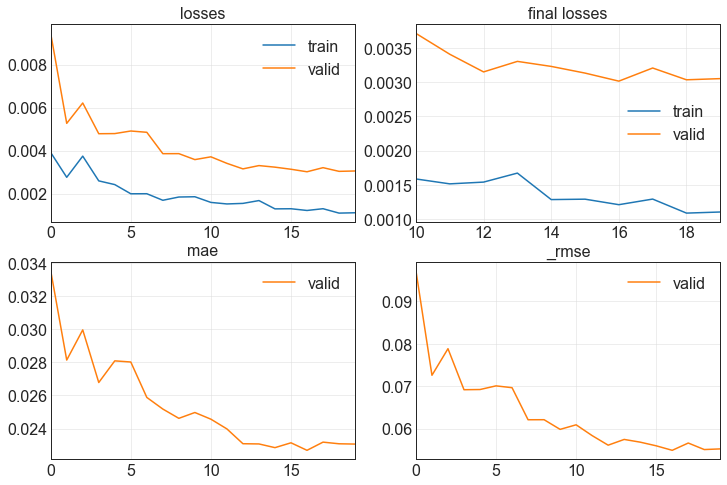

65.67578077316284                                                                                                      
[0.0011063122656196356, 0.0030512504745274782, 0.023064306005835533, 0.05523812770843506]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 29%|████████████▊                               | 29/100 [27:06<1:01:57, 52.36s/trial, best loss: 0.00303838262334466]

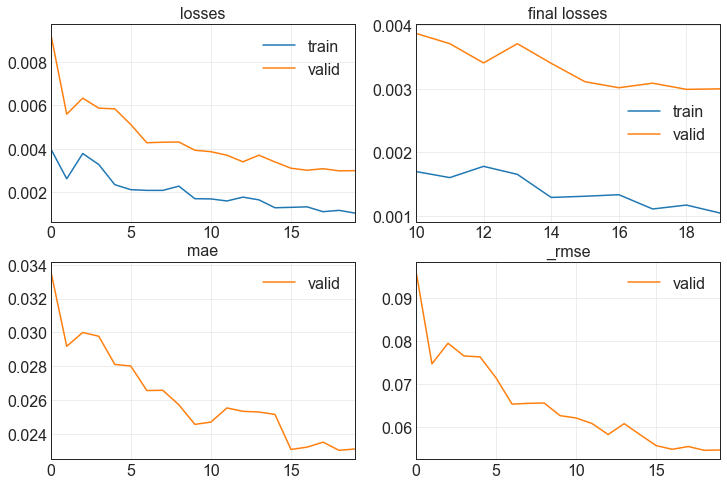

65.27834248542786                                                                                                      
[0.0010483944788575172, 0.0029982980340719223, 0.023100130259990692, 0.054756712168455124]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 30%|████████████▌                             | 30/100 [28:13<1:06:05, 56.66s/trial, best loss: 0.0029982980340719223]

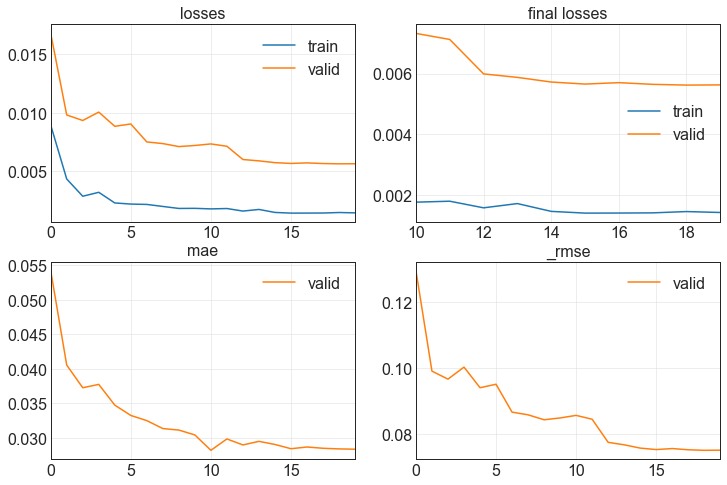

115.55818247795105                                                                                                     
[0.0014187481720000505, 0.005629893857985735, 0.028370991349220276, 0.07503261417150497]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 31%|█████████████                             | 31/100 [30:10<1:25:57, 74.75s/trial, best loss: 0.0029982980340719223]

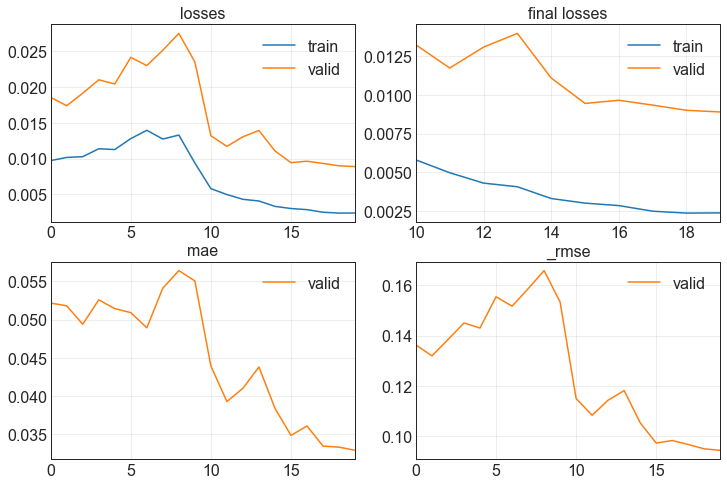

141.31567764282227                                                                                                     
[0.0023984198924154043, 0.00889296643435955, 0.03292344883084297, 0.09430252760648727]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 32%|█████████████▍                            | 32/100 [32:32<1:47:49, 95.14s/trial, best loss: 0.0029982980340719223]

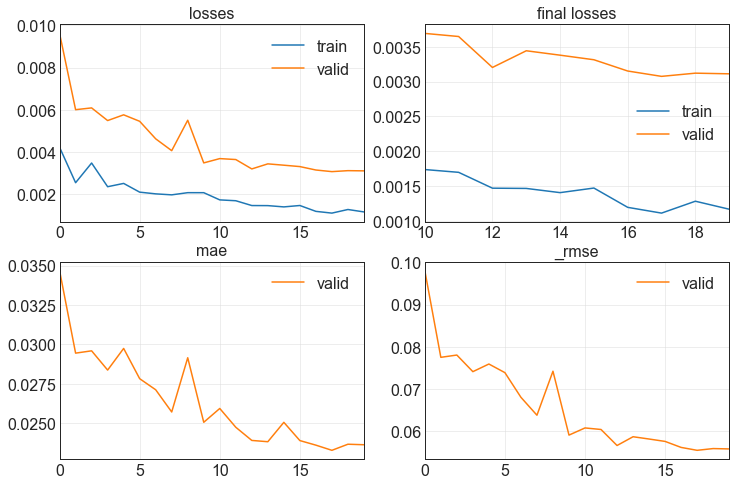

65.18819046020508                                                                                                      
[0.0011692907428368926, 0.003111914498731494, 0.02364605851471424, 0.05578454211354256]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 33%|█████████████▊                            | 33/100 [33:39<1:36:40, 86.57s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 12: early stopping                                                                          
 33%|█████████████▊                            | 33/100 [34:13<1:36:40, 86.57s/trial, best loss: 0.0029982980340719223]

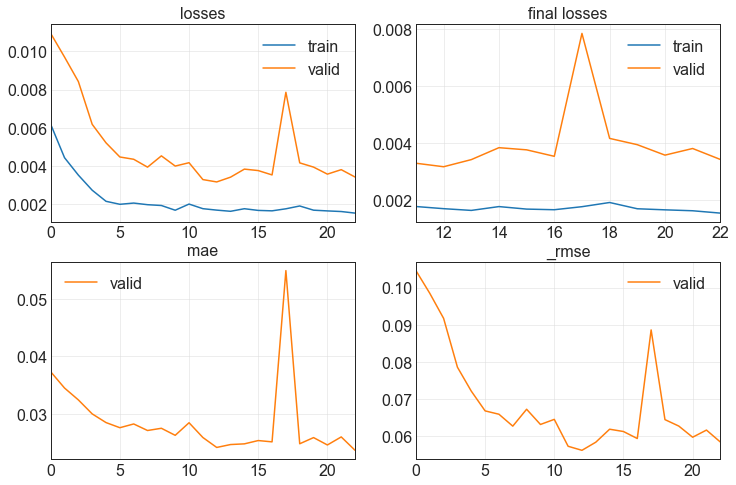

34.71056580543518                                                                                                      
[0.001535290153697133, 0.0034229473676532507, 0.023666435852646828, 0.058505963534116745]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 34%|██████████████▎                           | 34/100 [34:15<1:18:34, 71.44s/trial, best loss: 0.0029982980340719223]

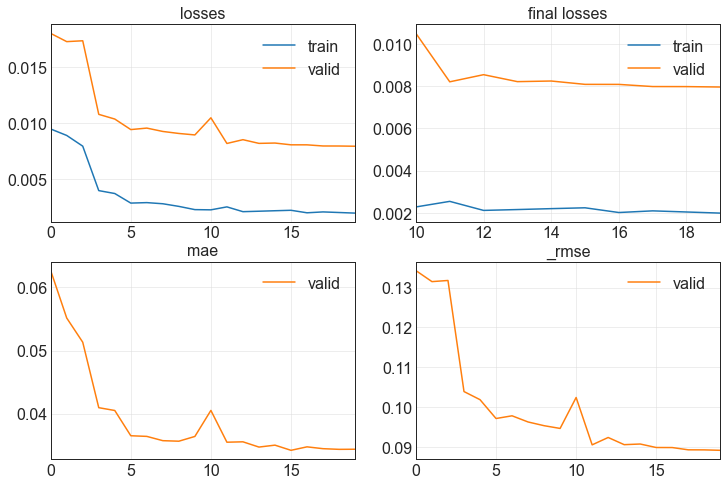

133.19048833847046                                                                                                     
[0.001984137576073408, 0.007951950654387474, 0.0343647375702858, 0.08917370438575745]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 35%|██████████████▋                           | 35/100 [36:30<1:37:55, 90.39s/trial, best loss: 0.0029982980340719223]

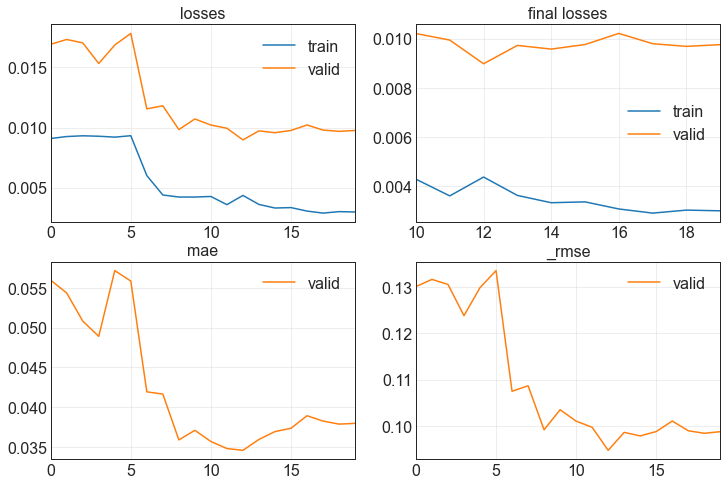

106.33956122398376                                                                                                     
[0.002979590557515621, 0.009756657294929028, 0.03794912248849869, 0.09877578914165497]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 36%|███████████████                           | 36/100 [38:18<1:41:58, 95.60s/trial, best loss: 0.0029982980340719223]

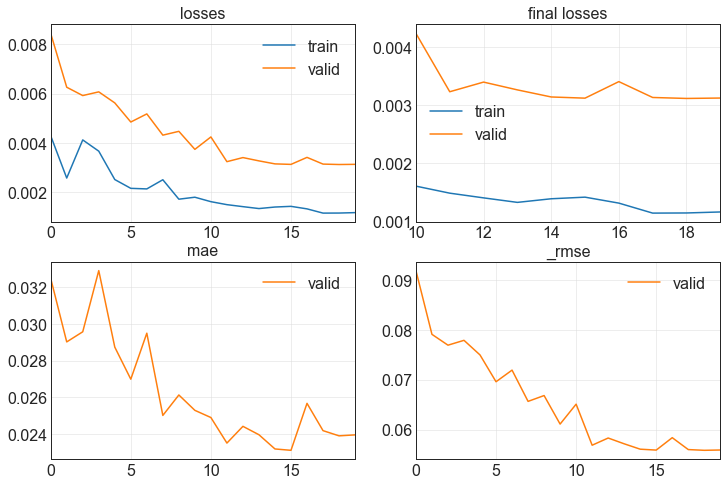

67.92693638801575                                                                                                      
[0.0011652588145807385, 0.0031250573229044676, 0.02394925430417061, 0.05590221285820007]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 37%|███████████████▌                          | 37/100 [39:27<1:32:06, 87.72s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 57: early stopping                                                                          
 37%|███████████████▌                          | 37/100 [42:04<1:32:06, 87.72s/trial, best loss: 0.0029982980340719223]

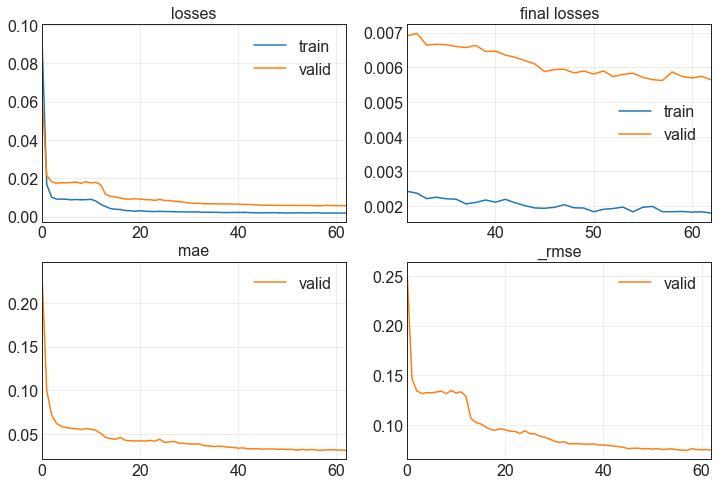

157.00759959220886                                                                                                     
[0.0018002489814534783, 0.005635168869048357, 0.03096087835729122, 0.07506775856018066]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 38%|███████████████▌                         | 38/100 [42:05<1:52:33, 108.93s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 2: early stopping                                                                           
 38%|███████████████▌                         | 38/100 [42:19<1:52:33, 108.93s/trial, best loss: 0.0029982980340719223]

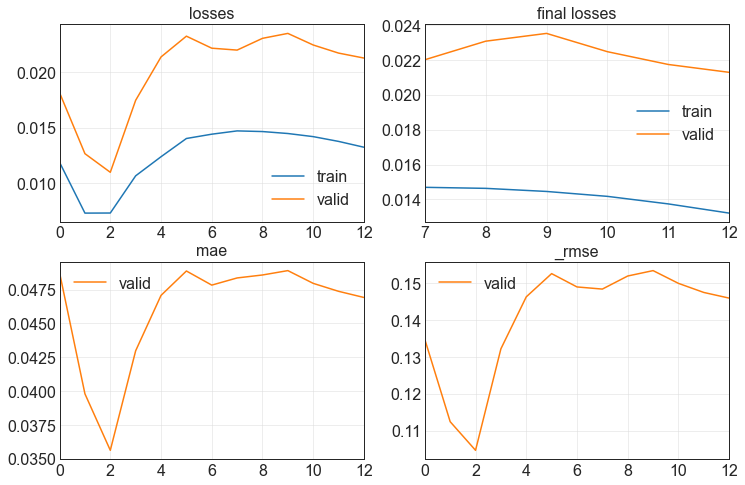

14.033339262008667                                                                                                     
[0.013217756524682045, 0.021281694993376732, 0.04691179096698761, 0.1458824723958969]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 39%|████████████████▍                         | 39/100 [42:21<1:22:13, 80.88s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 0: early stopping                                                                           
 39%|████████████████▍                         | 39/100 [43:04<1:22:13, 80.88s/trial, best loss: 0.0029982980340719223]

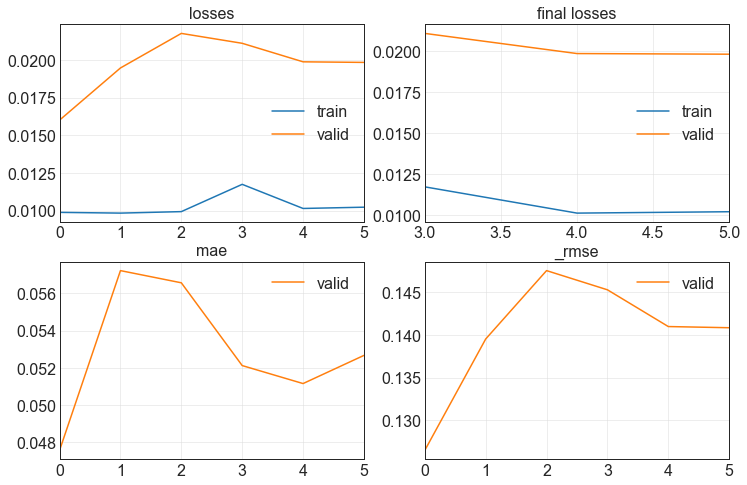

43.35348844528198                                                                                                      
[0.01022446621209383, 0.019829314202070236, 0.052667245268821716, 0.1408165842294693]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 40%|████████████████▊                         | 40/100 [43:06<1:10:04, 70.08s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 31: early stopping                                                                          
 40%|████████████████▊                         | 40/100 [48:19<1:10:04, 70.08s/trial, best loss: 0.0029982980340719223]

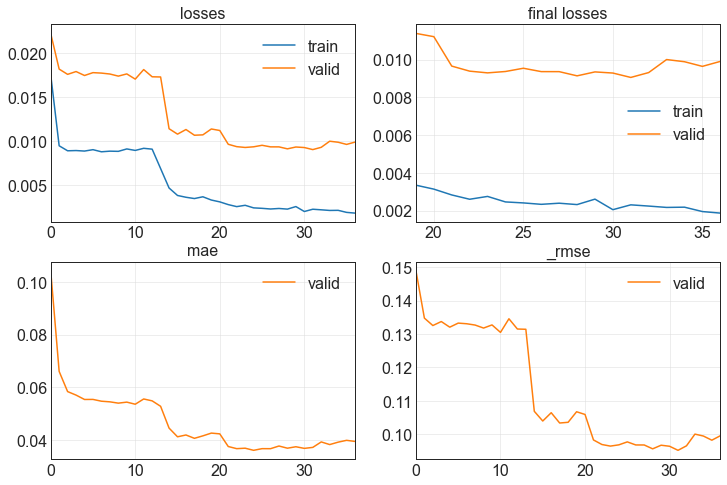

313.89358139038086                                                                                                     
[0.0018718913197517395, 0.009909044951200485, 0.039456211030483246, 0.09954418241977692]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 41%|████████████████▊                        | 41/100 [48:21<2:21:14, 143.64s/trial, best loss: 0.0029982980340719223]

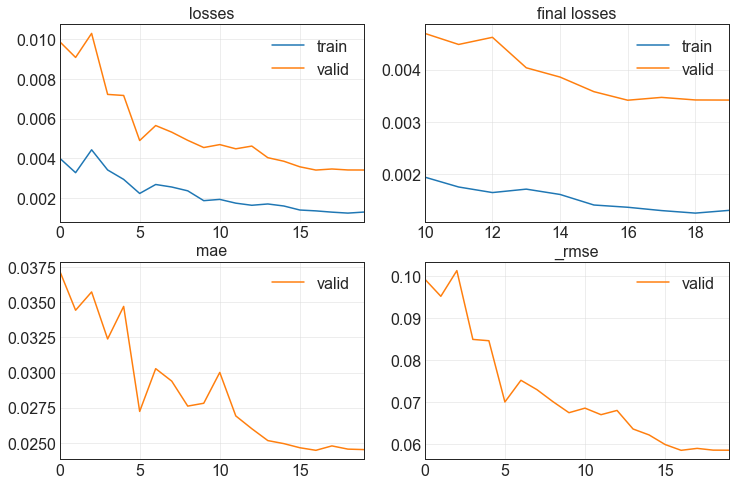

54.673765659332275                                                                                                     
[0.0013053847942501307, 0.00341846258379519, 0.024514000862836838, 0.05846761539578438]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 42%|█████████████████▏                       | 42/100 [49:17<1:53:28, 117.39s/trial, best loss: 0.0029982980340719223]

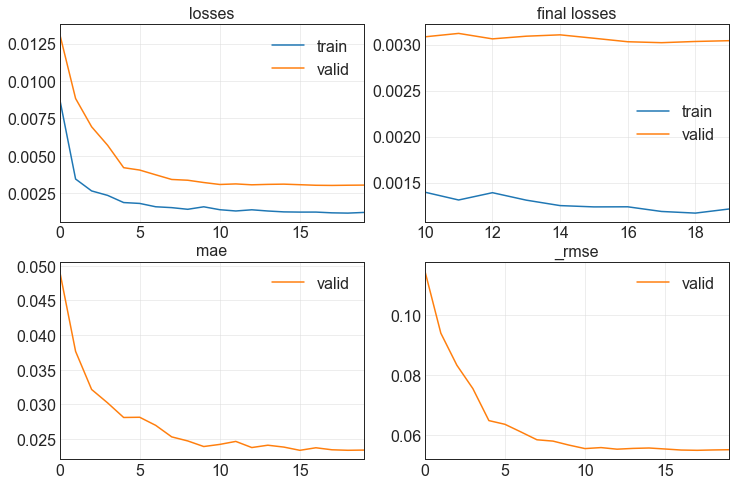

36.36624336242676                                                                                                      
[0.001214801101014018, 0.003042130032554269, 0.023413557559251785, 0.05515550822019577]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 43%|██████████████████                        | 43/100 [49:55<1:28:50, 93.52s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 2: early stopping                                                                           
 43%|██████████████████                        | 43/100 [50:10<1:28:50, 93.52s/trial, best loss: 0.0029982980340719223]

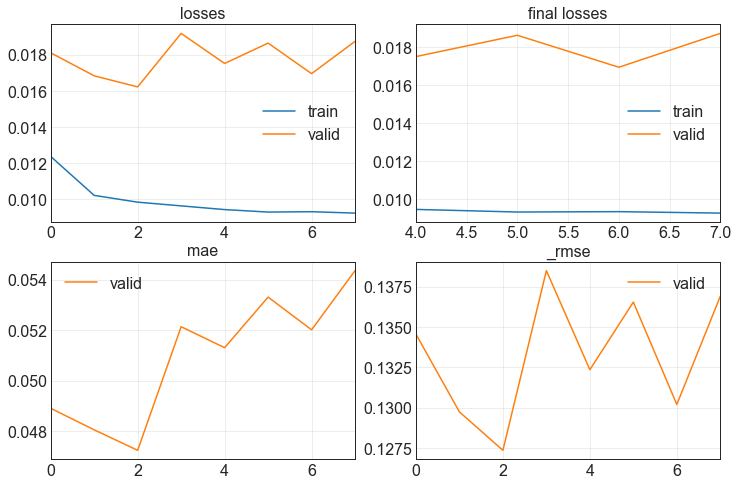

15.151434659957886                                                                                                     
[0.009243289940059185, 0.01874084584414959, 0.05435189977288246, 0.13689720630645752]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 44%|██████████████████▍                       | 44/100 [50:11<1:05:44, 70.43s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 4: early stopping                                                                           
 44%|██████████████████▍                       | 44/100 [51:21<1:05:44, 70.43s/trial, best loss: 0.0029982980340719223]

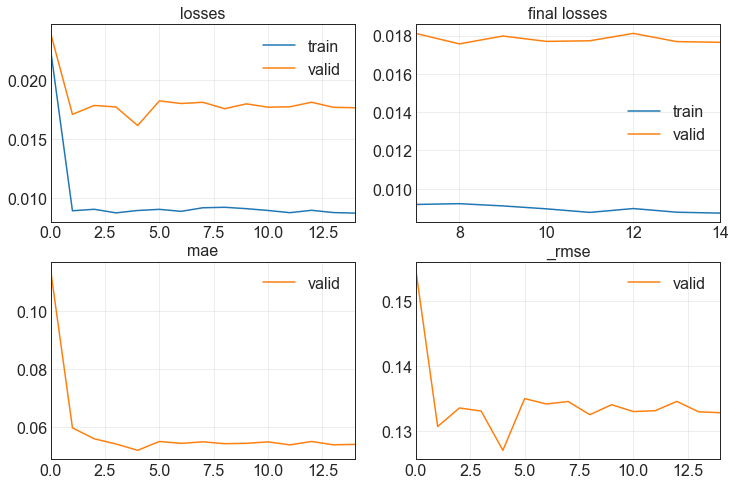

69.56178712844849                                                                                                      
[0.008726618252694607, 0.017647026106715202, 0.05416610836982727, 0.13284212350845337]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 45%|██████████████████▉                       | 45/100 [51:22<1:04:42, 70.59s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 7: early stopping                                                                           
 45%|██████████████████▉                       | 45/100 [52:02<1:04:42, 70.59s/trial, best loss: 0.0029982980340719223]

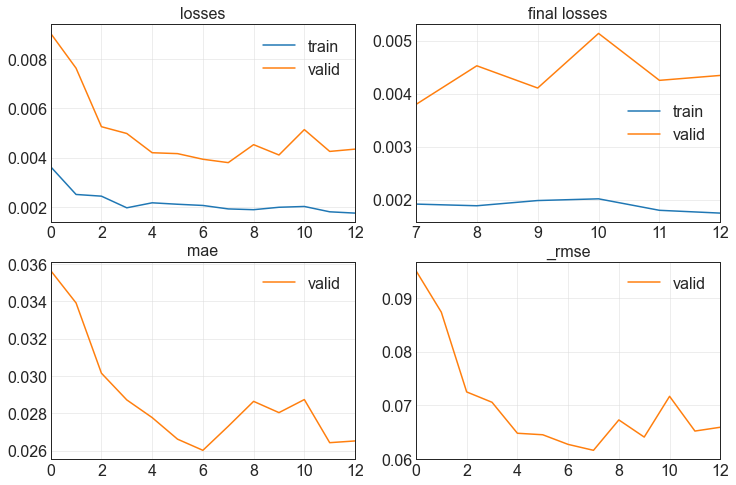

39.93813109397888                                                                                                      
[0.0017461817478761077, 0.004343577194958925, 0.026517225429415703, 0.06590580940246582]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 46%|████████████████████▏                       | 46/100 [52:04<55:38, 61.82s/trial, best loss: 0.0029982980340719223]

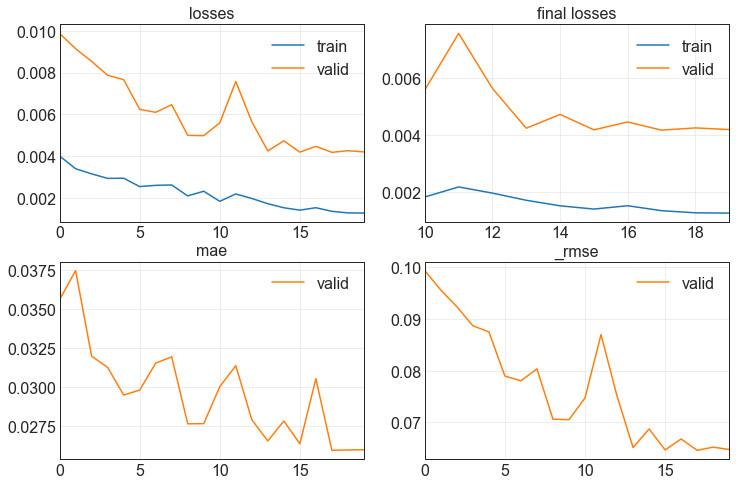

95.18337535858154                                                                                                      
[0.0012627344112843275, 0.004196110647171736, 0.02596096508204937, 0.06477738916873932]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 47%|███████████████████▋                      | 47/100 [53:40<1:03:49, 72.25s/trial, best loss: 0.0029982980340719223]

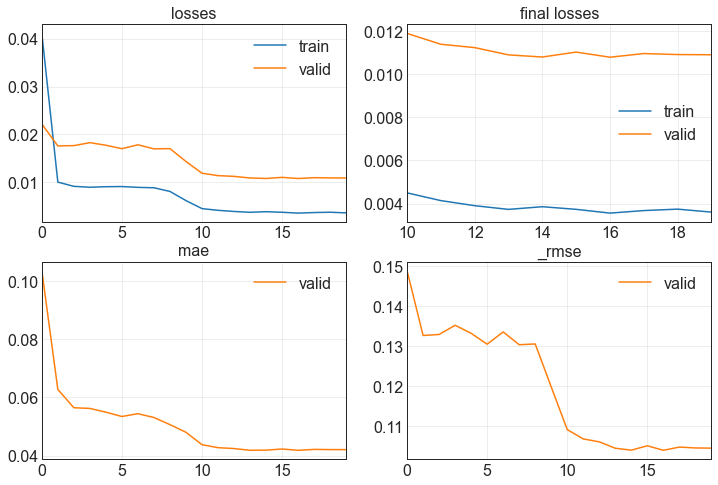

43.08141851425171                                                                                                      
[0.003607412101700902, 0.010900446213781834, 0.042032789438962936, 0.10440519452095032]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 48%|█████████████████████                       | 48/100 [54:25<55:23, 63.92s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 34: early stopping                                                                          
 48%|█████████████████████                       | 48/100 [55:05<55:23, 63.92s/trial, best loss: 0.0029982980340719223]

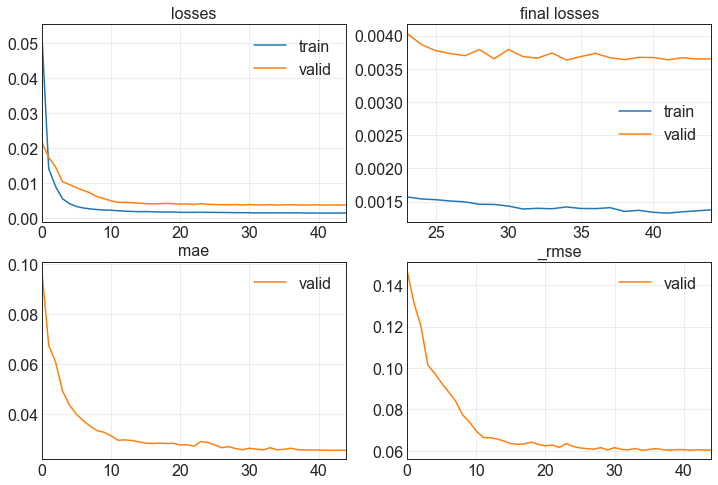

40.444955587387085                                                                                                     
[0.0013776689302176237, 0.003650193102657795, 0.025567766278982162, 0.06041682884097099]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 49%|█████████████████████▌                      | 49/100 [55:07<48:43, 57.32s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 8: early stopping                                                                           
 49%|█████████████████████▌                      | 49/100 [55:24<48:43, 57.32s/trial, best loss: 0.0029982980340719223]

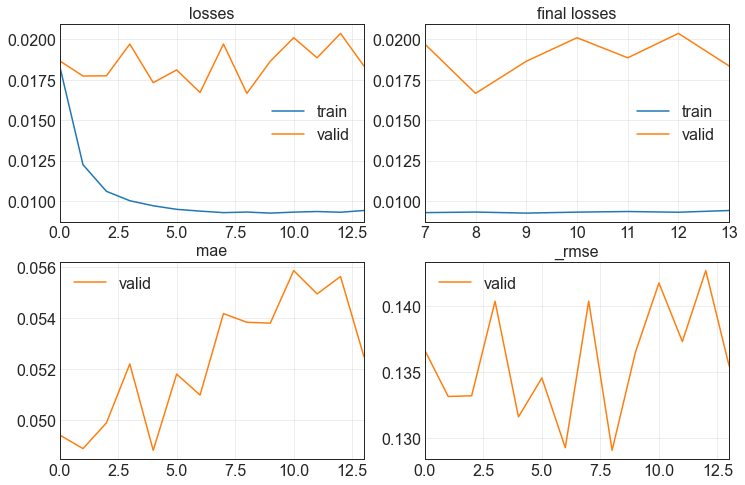

18.142415285110474                                                                                                     
[0.009413992054760456, 0.018352726474404335, 0.05249646678566933, 0.13547222316265106]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 50%|██████████████████████                      | 50/100 [55:26<38:20, 46.00s/trial, best loss: 0.0029982980340719223]

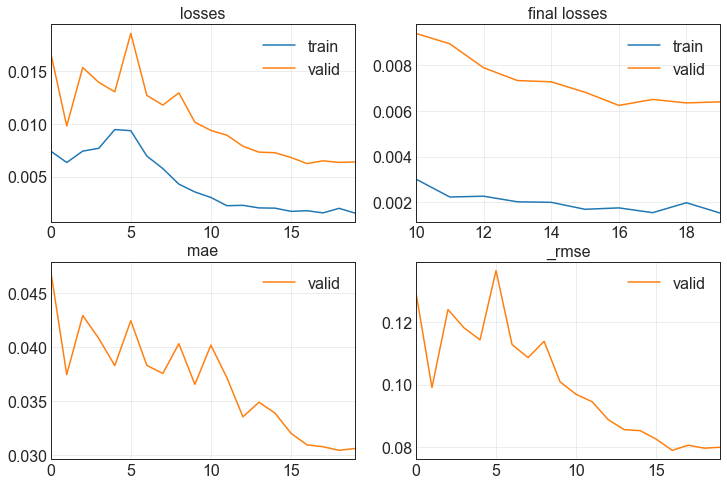

67.14556193351746                                                                                                      
[0.0015326584689319134, 0.006393285933881998, 0.030627908185124397, 0.07995802909135818]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 51%|██████████████████████▍                     | 51/100 [56:35<43:05, 52.77s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 19: early stopping                                                                          
 51%|██████████████████████▍                     | 51/100 [57:52<43:05, 52.77s/trial, best loss: 0.0029982980340719223]

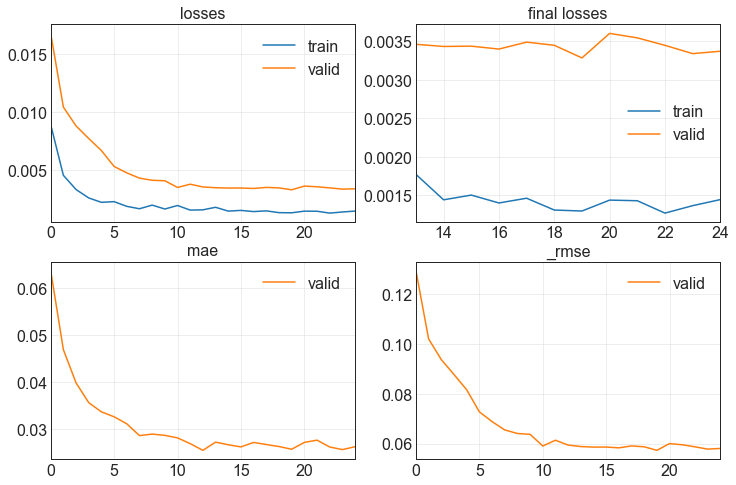

77.30443477630615                                                                                                      
[0.0014458977384492755, 0.0033704109955579042, 0.02627122402191162, 0.05805524066090584]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 52%|██████████████████████▉                     | 52/100 [57:54<48:26, 60.55s/trial, best loss: 0.0029982980340719223]

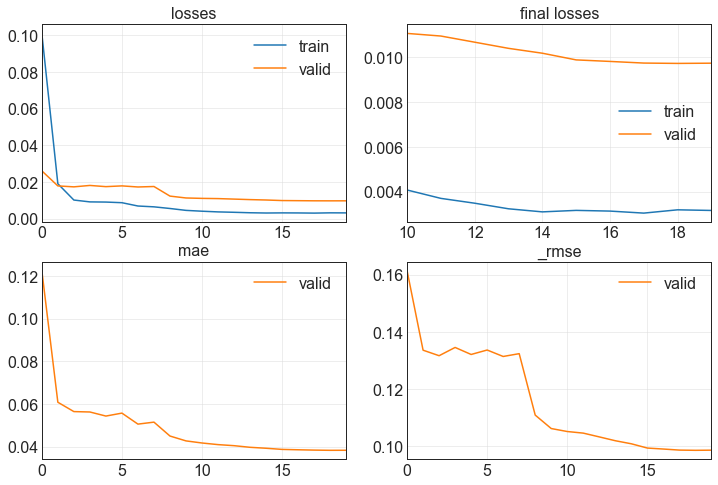

42.34156680107117                                                                                                      
[0.0031608403660357, 0.00973134022206068, 0.038296934217214584, 0.09864755719900131]                                   
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 53%|███████████████████████▎                    | 53/100 [58:37<43:29, 55.52s/trial, best loss: 0.0029982980340719223]

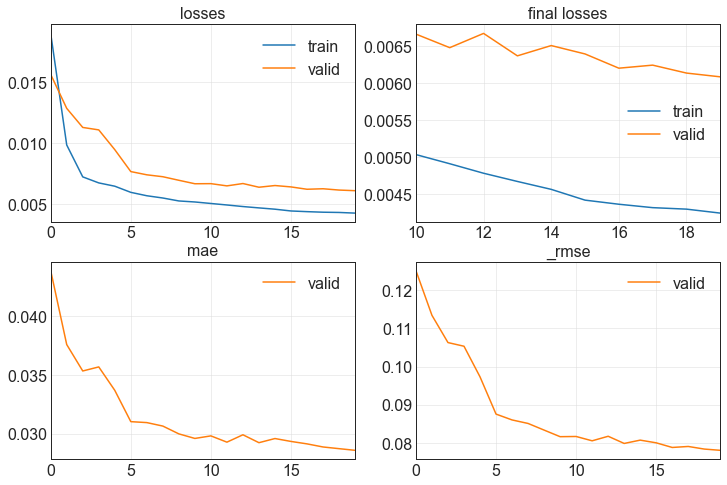

11.891479015350342                                                                                                     
[0.004241288173943758, 0.006088432855904102, 0.028573201969265938, 0.07802841067314148]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 54%|███████████████████████▊                    | 54/100 [58:51<32:51, 42.86s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 17: early stopping                                                                          
 54%|███████████████████████▊                    | 54/100 [59:40<32:51, 42.86s/trial, best loss: 0.0029982980340719223]

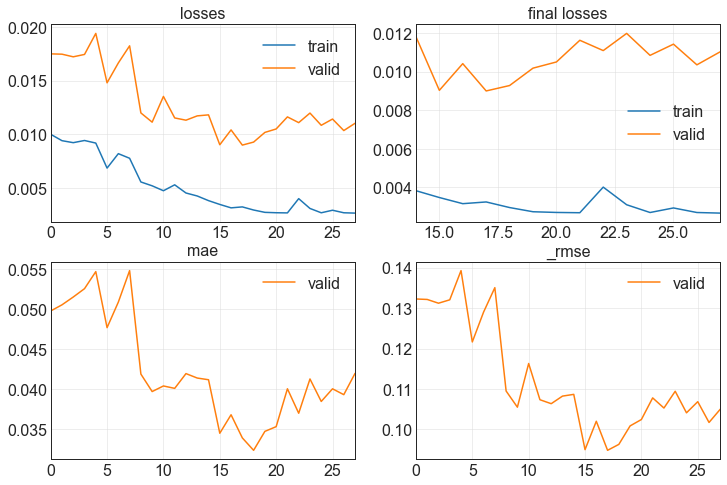

49.66571235656738                                                                                                      
[0.0026651062071323395, 0.011027565225958824, 0.041999343782663345, 0.10501222312450409]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 55%|████████████████████████▏                   | 55/100 [59:42<33:59, 45.32s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 5: early stopping                                                                           
 55%|███████████████████████                   | 55/100 [1:00:15<33:59, 45.32s/trial, best loss: 0.0029982980340719223]

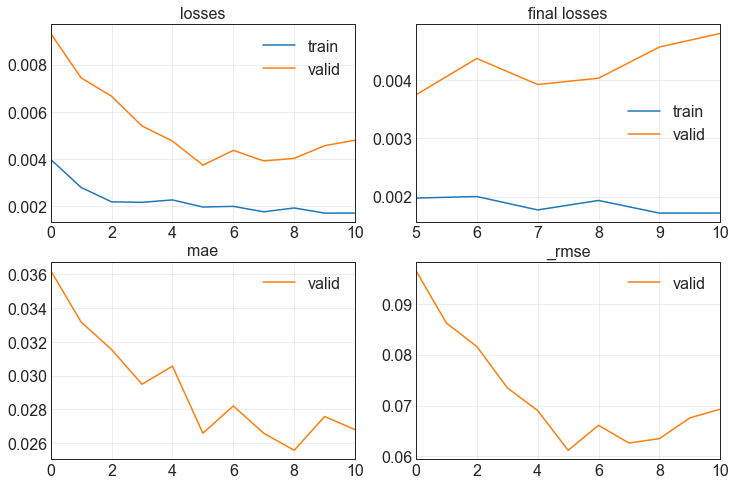

33.90950918197632                                                                                                      
[0.001718142768368125, 0.004801568575203419, 0.026795126497745514, 0.06929334998130798]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 56%|███████████████████████▌                  | 56/100 [1:00:17<31:02, 42.32s/trial, best loss: 0.0029982980340719223]

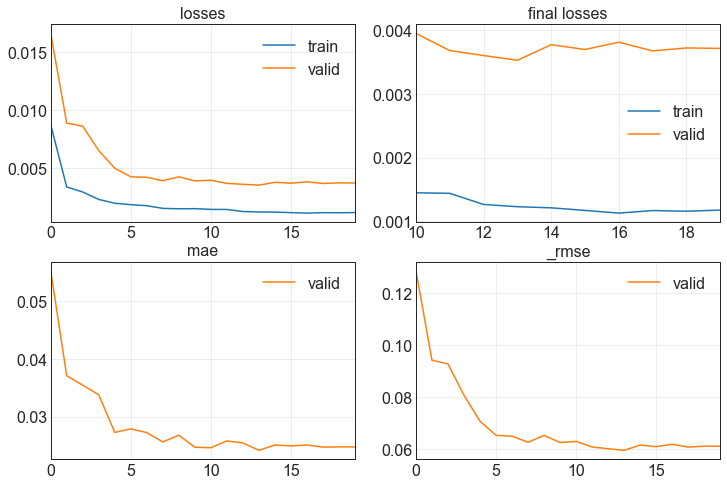

93.53098177909851                                                                                                      
[0.0011761318892240524, 0.003717951476573944, 0.024756593629717827, 0.060975003987550735]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 57%|███████████████████████▉                  | 57/100 [1:01:52<41:39, 58.13s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 2: early stopping                                                                           
 57%|███████████████████████▉                  | 57/100 [1:01:57<41:39, 58.13s/trial, best loss: 0.0029982980340719223]

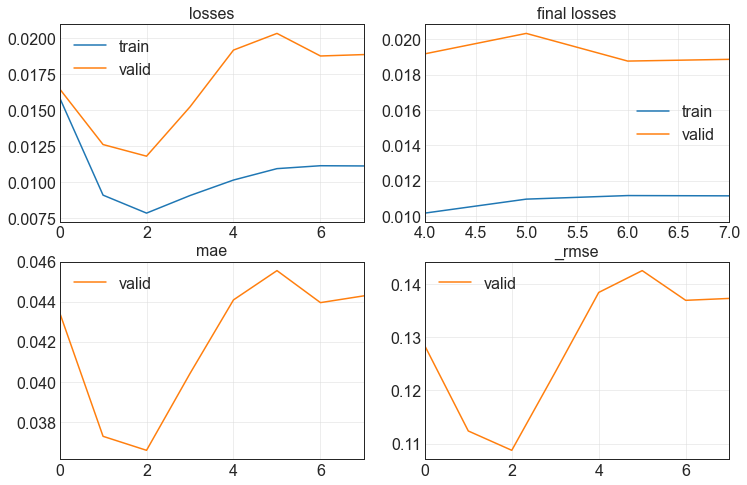

4.892413854598999                                                                                                      
[0.011141210794448853, 0.018862733617424965, 0.044291749596595764, 0.1373416632413864]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 58%|████████████████████████▎                 | 58/100 [1:01:58<29:48, 42.59s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 8: early stopping                                                                           
 58%|████████████████████████▎                 | 58/100 [1:02:22<29:48, 42.59s/trial, best loss: 0.0029982980340719223]

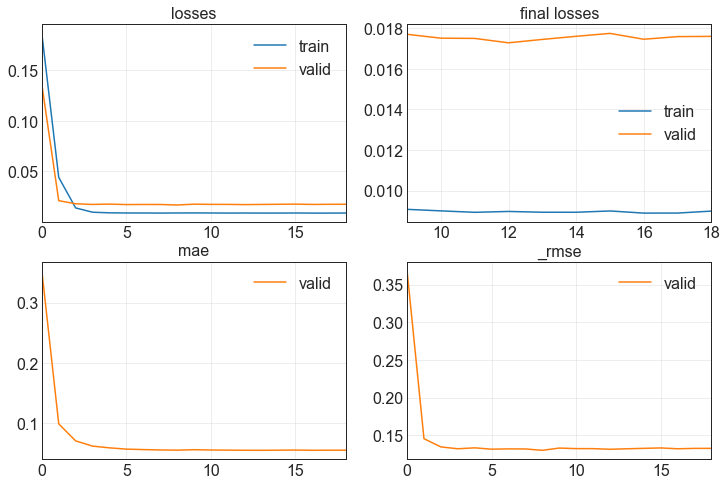

24.192009449005127                                                                                                     
[0.008988533169031143, 0.017605258151888847, 0.054705433547496796, 0.13268479704856873]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 59%|████████████████████████▊                 | 59/100 [1:02:24<25:37, 37.49s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 10: early stopping                                                                          
 59%|████████████████████████▊                 | 59/100 [1:03:17<25:37, 37.49s/trial, best loss: 0.0029982980340719223]

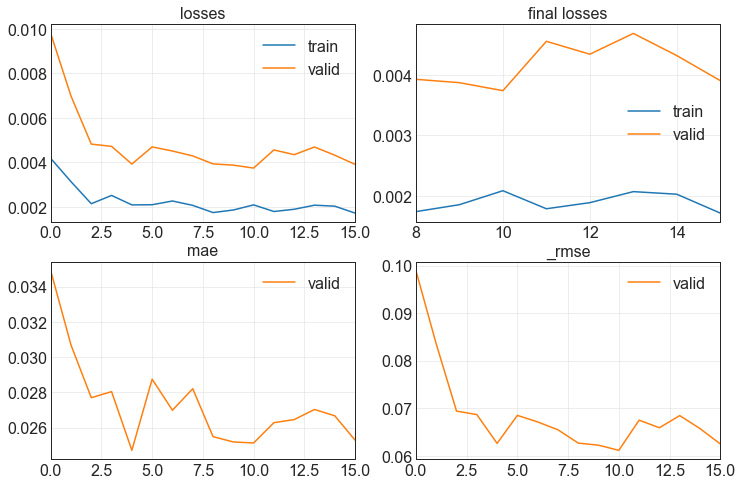

53.769378662109375                                                                                                     
[0.001715610851533711, 0.00390537828207016, 0.025296133011579514, 0.062493015080690384]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 10}
GRU                                                                                                                    
 60%|█████████████████████████▏                | 60/100 [1:03:19<28:32, 42.80s/trial, best loss: 0.0029982980340719223]

No improvement since epoch 27: early stopping                                                                          
 60%|█████████████████████████▏                | 60/100 [1:04:52<28:32, 42.80s/trial, best loss: 0.0029982980340719223]

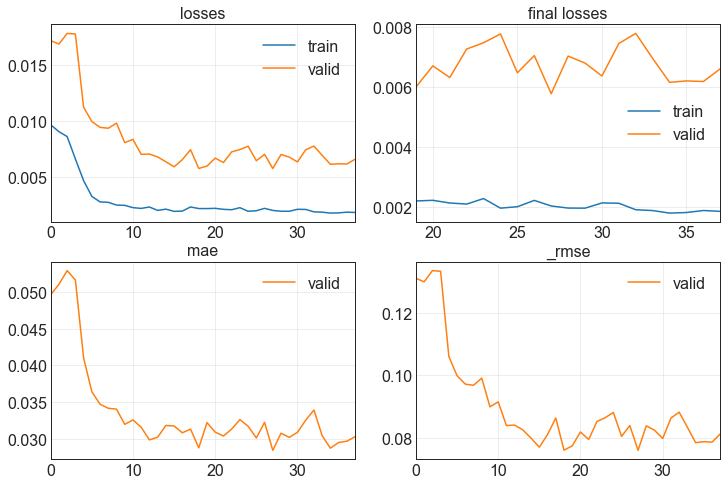

93.49767804145813                                                                                                      
[0.0018486237386241555, 0.006604242138564587, 0.030282331630587578, 0.08126647770404816]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 61%|█████████████████████████▌                | 61/100 [1:04:54<37:59, 58.45s/trial, best loss: 0.0029982980340719223]

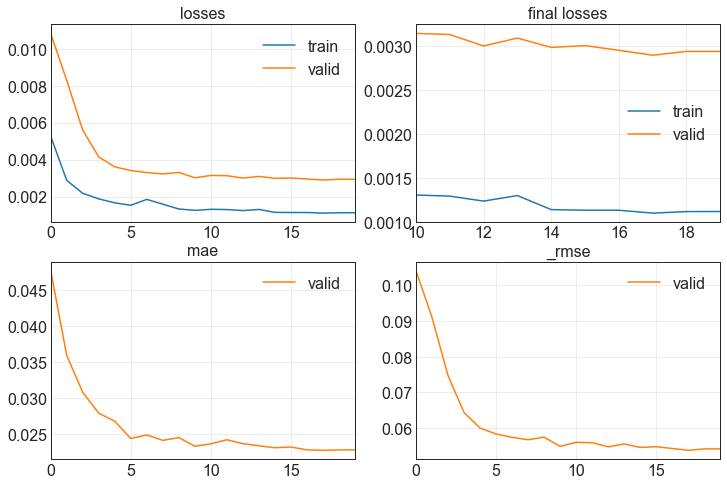

69.11248135566711                                                                                                      
[0.0011178262066096067, 0.0029364496003836393, 0.02283414453268051, 0.05418901890516281]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 62%|██████████████████████████                | 62/100 [1:06:05<39:18, 62.07s/trial, best loss: 0.0029364496003836393]

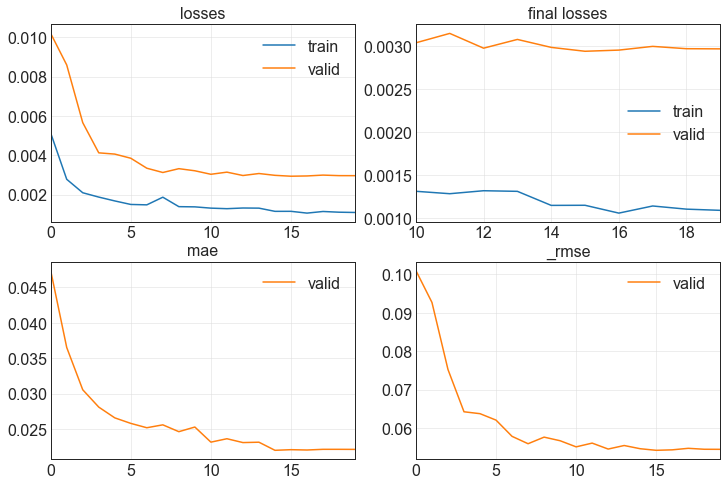

68.67161107063293                                                                                                      
[0.00109227339271456, 0.002964094979688525, 0.022139033302664757, 0.05444350466132164]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 63%|██████████████████████████▍               | 63/100 [1:07:15<39:46, 64.49s/trial, best loss: 0.0029364496003836393]

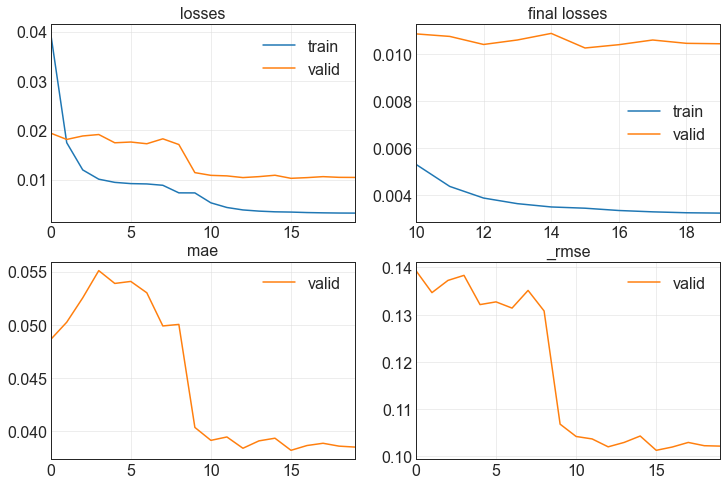

23.40803360939026                                                                                                      
[0.0032155648805201054, 0.010443088598549366, 0.03850923478603363, 0.10219143331050873]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 64%|██████████████████████████▉               | 64/100 [1:07:40<31:33, 52.61s/trial, best loss: 0.0029364496003836393]

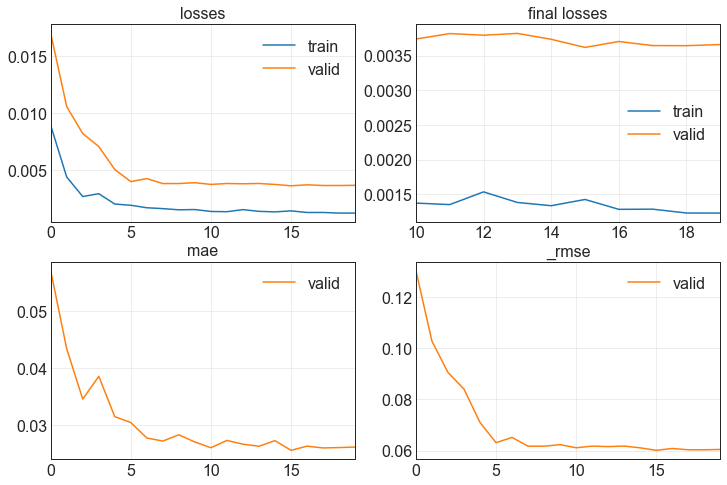

53.32081413269043                                                                                                      
[0.0012277145870029926, 0.0036599559243768454, 0.02619967795908451, 0.06049756705760956]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 65%|███████████████████████████▎              | 65/100 [1:08:35<31:03, 53.25s/trial, best loss: 0.0029364496003836393]

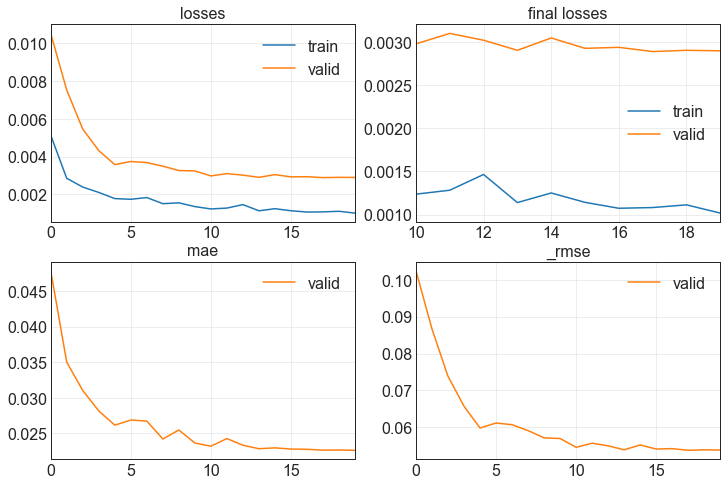

67.44067025184631                                                                                                      
[0.0010168406879529357, 0.0028997096233069897, 0.022628361359238625, 0.05384896323084831]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 66%|███████████████████████████▋              | 66/100 [1:09:43<32:50, 57.95s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 11: early stopping                                                                          
 66%|███████████████████████████▋              | 66/100 [1:10:42<32:50, 57.95s/trial, best loss: 0.0028997096233069897]

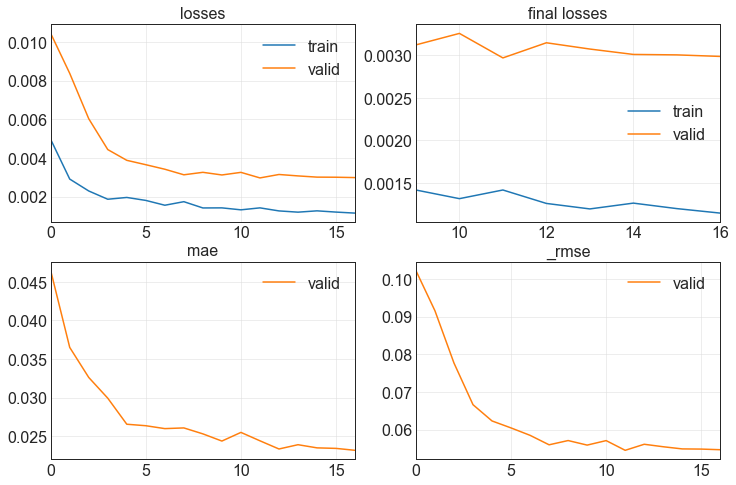

59.22665357589722                                                                                                      
[0.0011473222402855754, 0.002984672551974654, 0.0231808852404356, 0.05463215708732605]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 67%|████████████████████████████▏             | 67/100 [1:10:44<32:18, 58.75s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 13: early stopping                                                                          
 67%|████████████████████████████▏             | 67/100 [1:11:49<32:18, 58.75s/trial, best loss: 0.0028997096233069897]

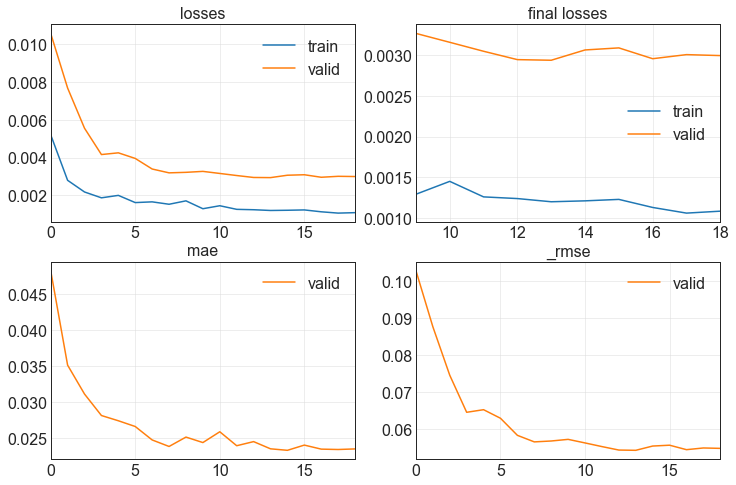

64.97098016738892                                                                                                      
[0.001084200106561184, 0.0029970193281769753, 0.02349310740828514, 0.05474504083395004]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 68%|████████████████████████████▌             | 68/100 [1:11:51<32:33, 61.05s/trial, best loss: 0.0028997096233069897]

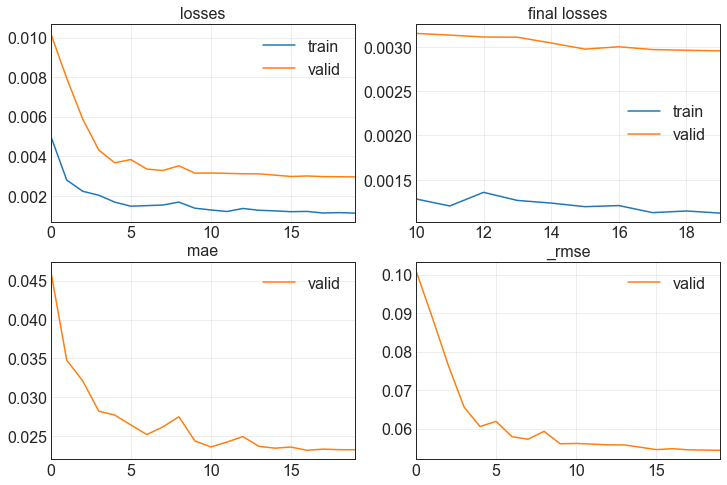

68.87718987464905                                                                                                      
[0.0011237466242164373, 0.0029552725609391928, 0.023239418864250183, 0.05436241254210472]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 69%|████████████████████████████▉             | 69/100 [1:13:01<32:59, 63.84s/trial, best loss: 0.0028997096233069897]

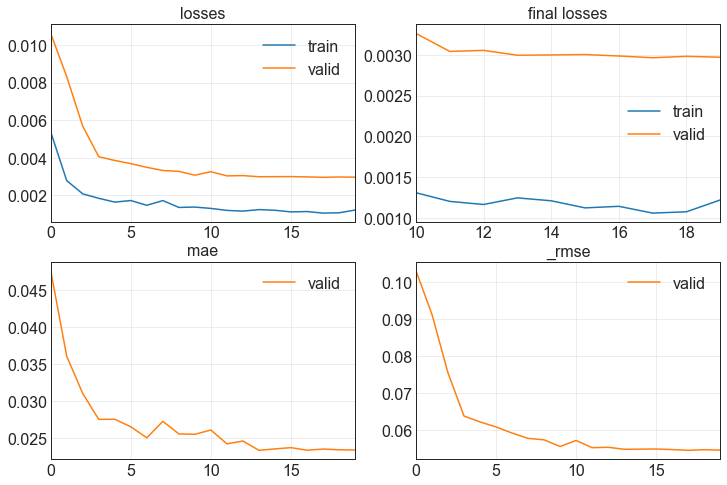

66.89060878753662                                                                                                      
[0.001221664366312325, 0.002970205619931221, 0.02343912608921528, 0.054499588906764984]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 70%|█████████████████████████████▍            | 70/100 [1:14:09<32:35, 65.19s/trial, best loss: 0.0028997096233069897]

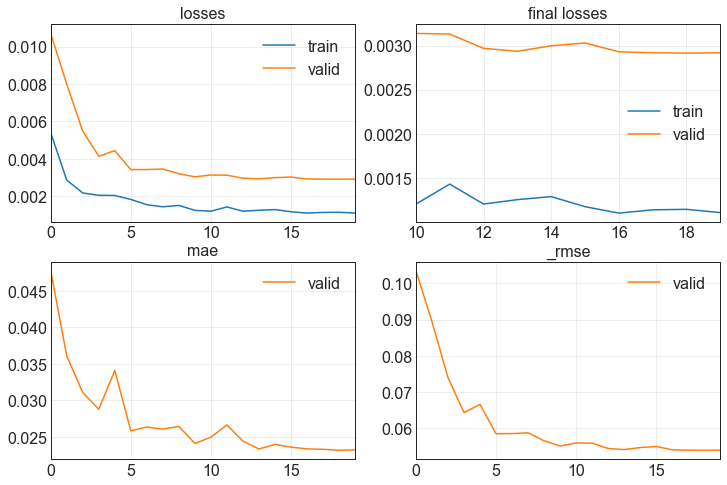

67.6449978351593                                                                                                       
[0.0011088978499174118, 0.0029184771701693535, 0.023208709433674812, 0.054022930562496185]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 71%|█████████████████████████████▊            | 71/100 [1:15:18<32:04, 66.36s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 9: early stopping                                                                           
 71%|█████████████████████████████▊            | 71/100 [1:16:09<32:04, 66.36s/trial, best loss: 0.0028997096233069897]

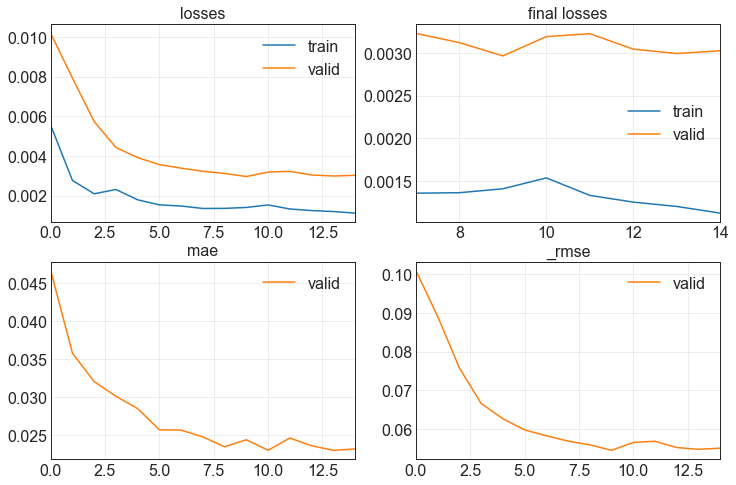

51.11701679229736                                                                                                      
[0.0011222678003832698, 0.00302662281319499, 0.02319745533168316, 0.055014751851558685]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 72%|██████████████████████████████▏           | 72/100 [1:16:11<29:01, 62.21s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 10: early stopping                                                                          
 72%|██████████████████████████████▏           | 72/100 [1:17:23<29:01, 62.21s/trial, best loss: 0.0028997096233069897]

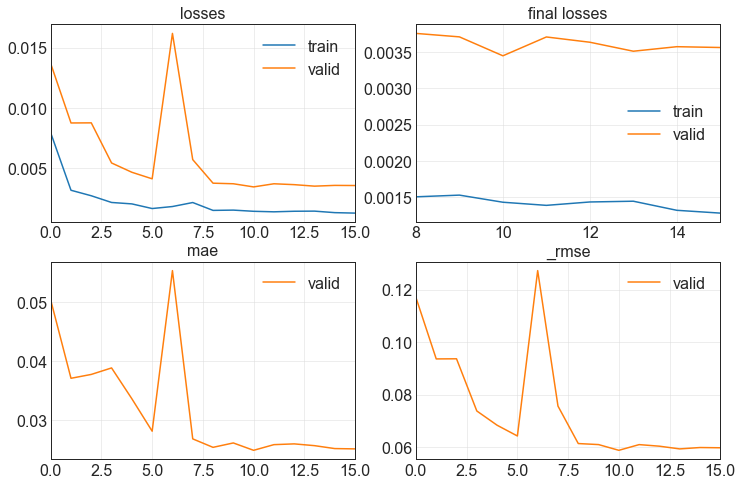

72.88697266578674                                                                                                      
[0.0012780806282535195, 0.0035656390246003866, 0.025101248174905777, 0.0597129762172699]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 73%|██████████████████████████████▋           | 73/100 [1:17:25<29:37, 65.83s/trial, best loss: 0.0028997096233069897]

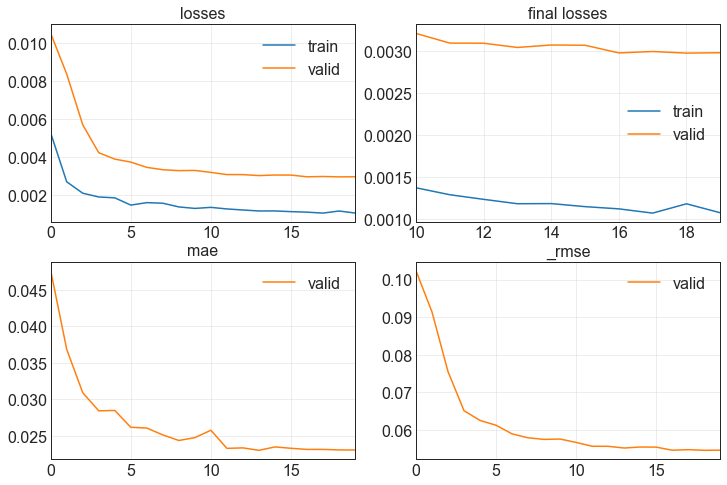

65.07500004768372                                                                                                      
[0.001078532193787396, 0.0029780538752675056, 0.023043595254421234, 0.054571546614170074]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 74%|███████████████████████████████           | 74/100 [1:18:32<28:36, 66.03s/trial, best loss: 0.0028997096233069897]

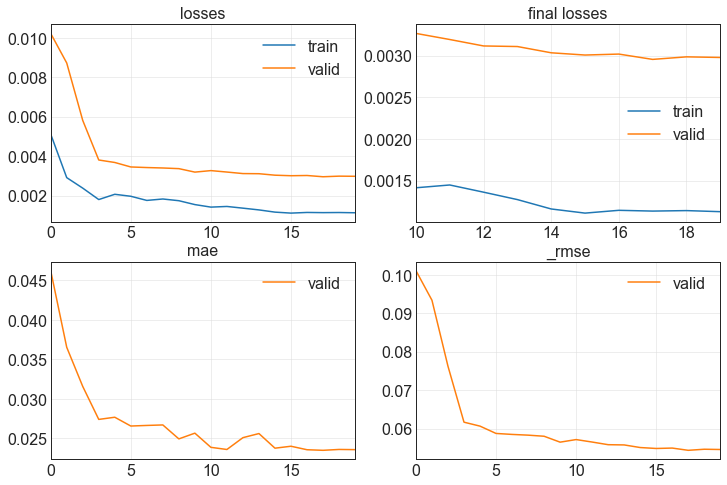

65.3388979434967                                                                                                       
[0.0011283444473519921, 0.00297708623111248, 0.02354835346341133, 0.054562680423259735]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 75%|███████████████████████████████▌          | 75/100 [1:19:38<27:36, 66.24s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 5: early stopping                                                                           
 75%|███████████████████████████████▌          | 75/100 [1:19:58<27:36, 66.24s/trial, best loss: 0.0028997096233069897]

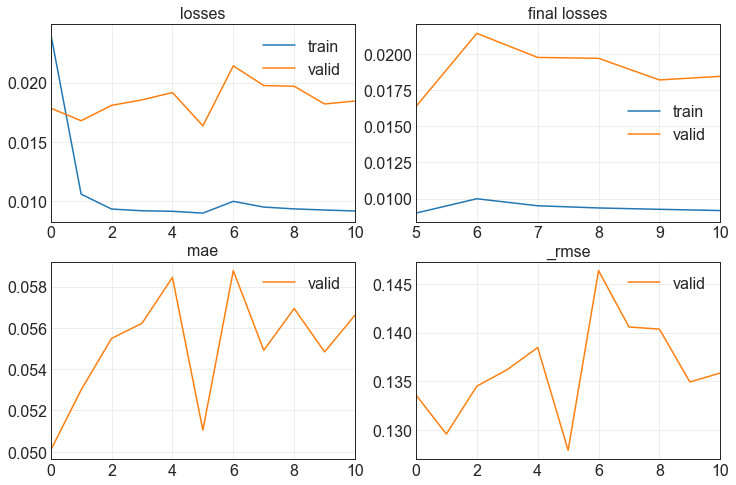

20.526302814483643                                                                                                     
[0.0091724693775177, 0.018454326316714287, 0.05661804974079132, 0.13584668934345245]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 76%|███████████████████████████████▉          | 76/100 [1:20:00<21:10, 52.95s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 19: early stopping                                                                          
 76%|███████████████████████████████▉          | 76/100 [1:22:24<21:10, 52.95s/trial, best loss: 0.0028997096233069897]

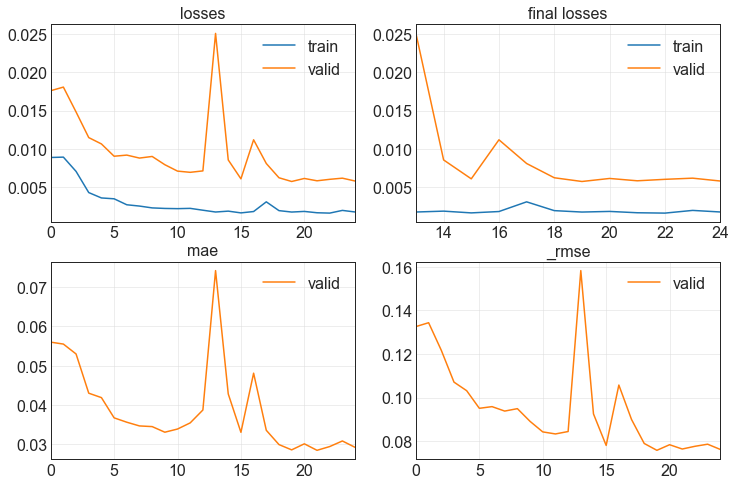

144.67541360855103                                                                                                     
[0.0017569322371855378, 0.005798550322651863, 0.029245123267173767, 0.07614819705486298]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 77%|████████████████████████████████▎         | 77/100 [1:22:26<31:00, 80.89s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 22: early stopping                                                                          
 77%|████████████████████████████████▎         | 77/100 [1:23:08<31:00, 80.89s/trial, best loss: 0.0028997096233069897]

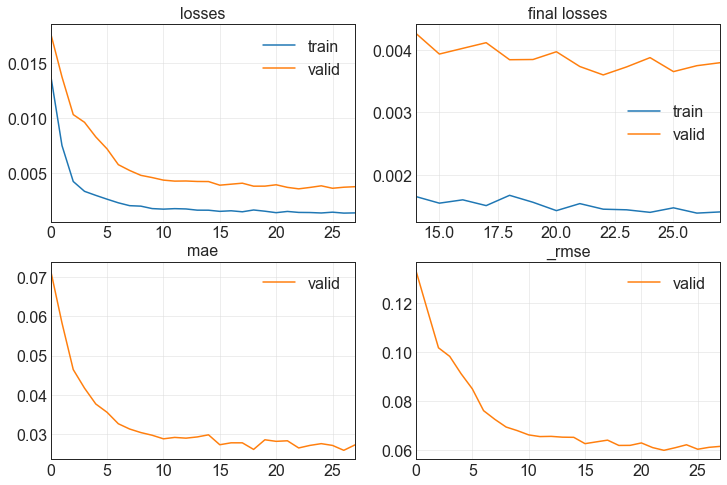

41.7424795627594                                                                                                       
[0.0014149638591334224, 0.0037937453016638756, 0.027243725955486298, 0.06159337982535362]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 78%|████████████████████████████████▊         | 78/100 [1:23:09<25:30, 69.58s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 13: early stopping                                                                          
 78%|████████████████████████████████▊         | 78/100 [1:25:24<25:30, 69.58s/trial, best loss: 0.0028997096233069897]

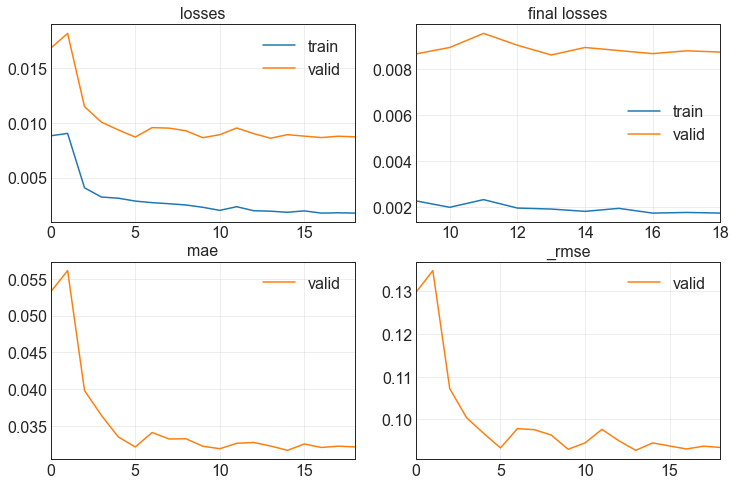

135.09860849380493                                                                                                     
[0.0017534543294459581, 0.008732044138014317, 0.03214733302593231, 0.09344541281461716]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 79%|█████████████████████████████████▏        | 79/100 [1:25:26<31:22, 89.65s/trial, best loss: 0.0028997096233069897]

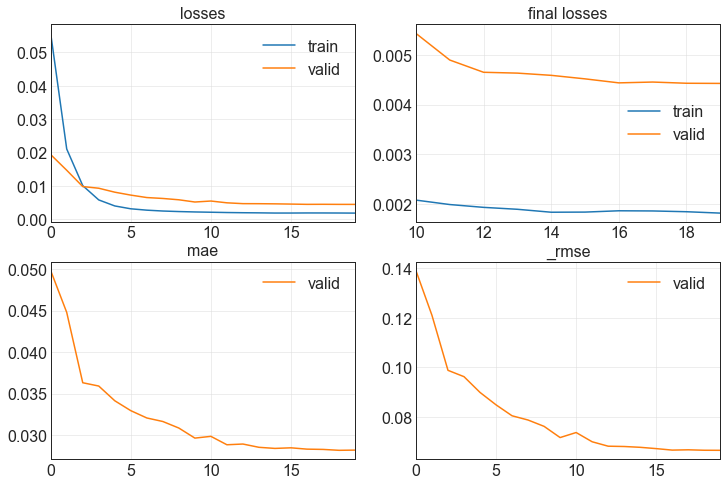

11.3281729221344                                                                                                       
[0.0018112544203177094, 0.004425234626978636, 0.02817683108150959, 0.06652243435382843]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 80%|█████████████████████████████████▌        | 80/100 [1:25:39<22:11, 66.58s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 12: early stopping                                                                          
 80%|█████████████████████████████████▌        | 80/100 [1:27:06<22:11, 66.58s/trial, best loss: 0.0028997096233069897]

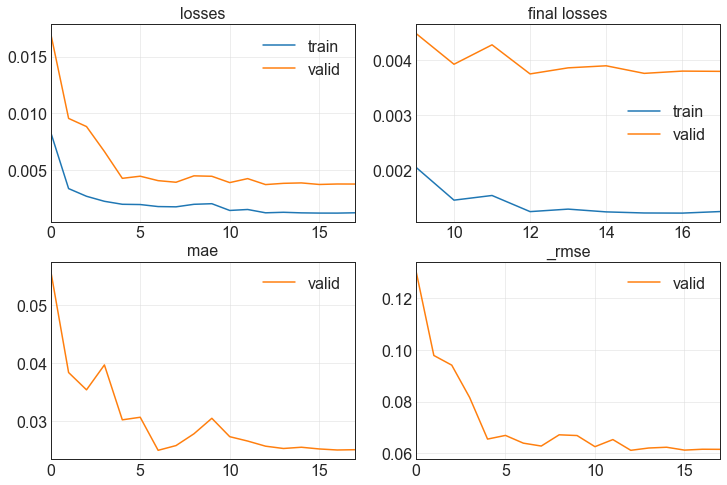

88.05652213096619                                                                                                      
[0.0012631022837013006, 0.003790919203311205, 0.02515280805528164, 0.061570435762405396]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 81%|██████████████████████████████████        | 81/100 [1:27:08<23:15, 73.45s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 51: early stopping                                                                          
 81%|██████████████████████████████████        | 81/100 [1:27:50<23:15, 73.45s/trial, best loss: 0.0028997096233069897]

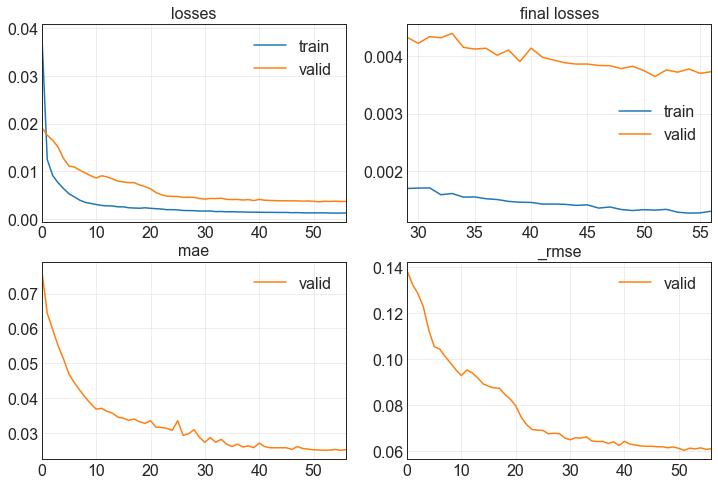

42.43404006958008                                                                                                      
[0.0013084016973152757, 0.0037259100936353207, 0.025190960615873337, 0.061040230095386505]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 82%|██████████████████████████████████▍       | 82/100 [1:27:52<19:22, 64.58s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 6: early stopping                                                                           
 82%|██████████████████████████████████▍       | 82/100 [1:29:18<19:22, 64.58s/trial, best loss: 0.0028997096233069897]

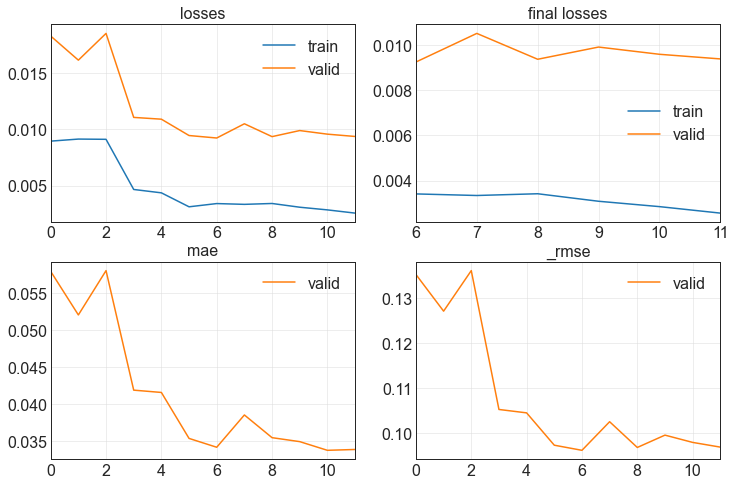

86.28984069824219                                                                                                      
[0.002560121240094304, 0.009380212984979153, 0.03390651196241379, 0.09685152024030685]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 83%|██████████████████████████████████▊       | 83/100 [1:29:20<20:15, 71.53s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 30: early stopping                                                                          
 83%|██████████████████████████████████▊       | 83/100 [1:30:17<20:15, 71.53s/trial, best loss: 0.0028997096233069897]

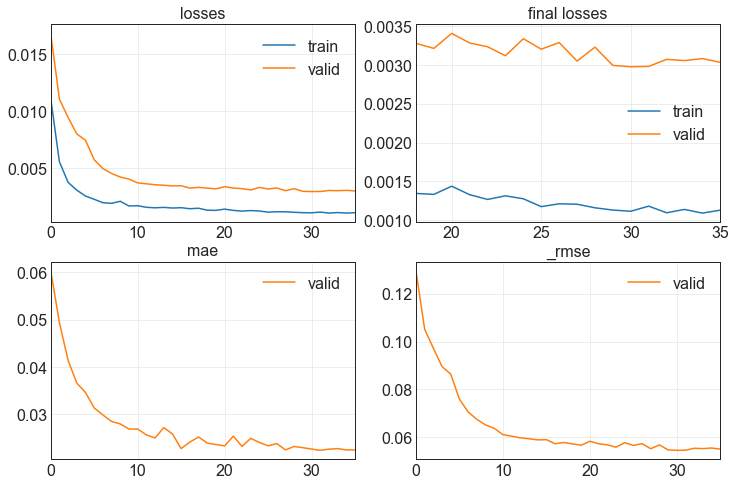

57.03425121307373                                                                                                      
[0.001129553304053843, 0.00303254253230989, 0.02250875160098076, 0.055068522691726685]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 84%|███████████████████████████████████▎      | 84/100 [1:30:18<18:01, 67.62s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 1: early stopping                                                                           
 84%|███████████████████████████████████▎      | 84/100 [1:30:58<18:01, 67.62s/trial, best loss: 0.0028997096233069897]

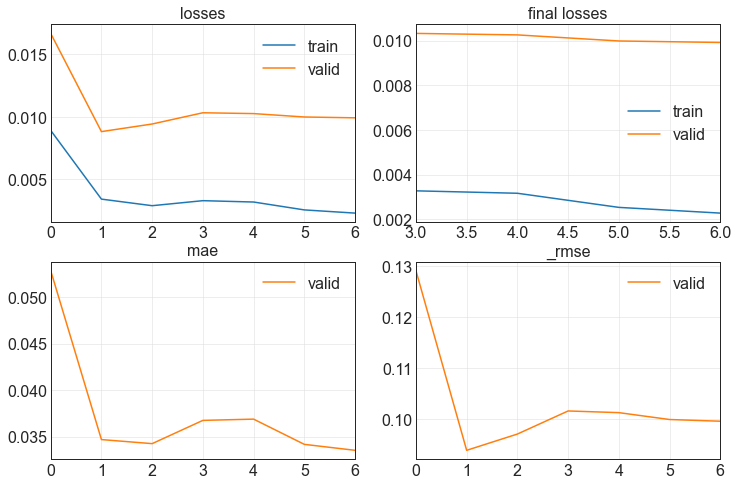

40.47571086883545                                                                                                      
[0.0022781032603234053, 0.00991244800388813, 0.033532749861478806, 0.09956127405166626]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 85%|███████████████████████████████████▋      | 85/100 [1:31:00<14:58, 59.91s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 12: early stopping                                                                          
 85%|███████████████████████████████████▋      | 85/100 [1:31:48<14:58, 59.91s/trial, best loss: 0.0028997096233069897]

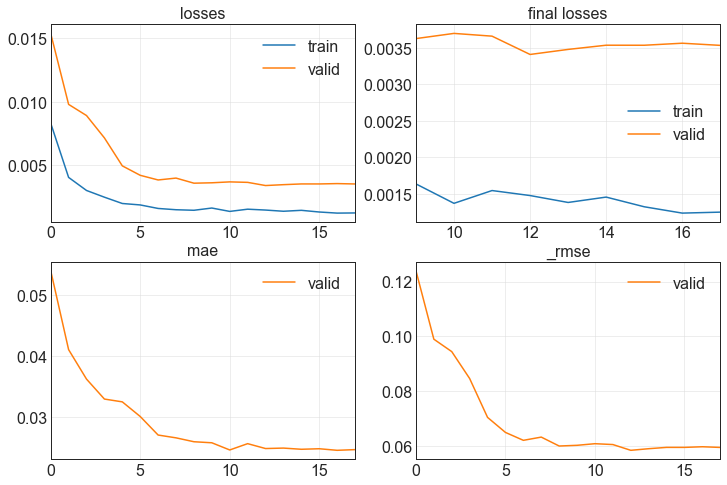

48.07205319404602                                                                                                      
[0.0012515055714175105, 0.0035325379576534033, 0.024575194343924522, 0.0594351552426815]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 86%|████████████████████████████████████      | 86/100 [1:31:50<13:14, 56.79s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 10: early stopping                                                                          
 86%|████████████████████████████████████      | 86/100 [1:32:07<13:14, 56.79s/trial, best loss: 0.0028997096233069897]

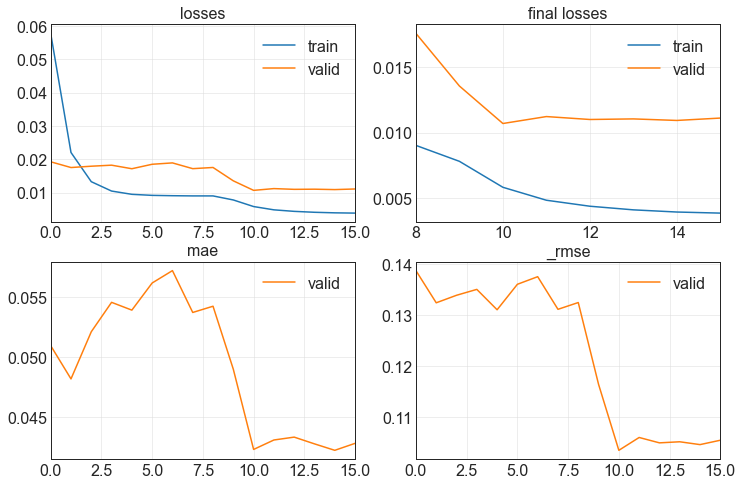

17.578257083892822                                                                                                     
[0.0038798863533884287, 0.011112148873507977, 0.04282471165060997, 0.10541417449712753]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 87%|████████████████████████████████████▌     | 87/100 [1:32:09<09:50, 45.45s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 49: early stopping                                                                          
 87%|████████████████████████████████████▌     | 87/100 [1:35:15<09:50, 45.45s/trial, best loss: 0.0028997096233069897]

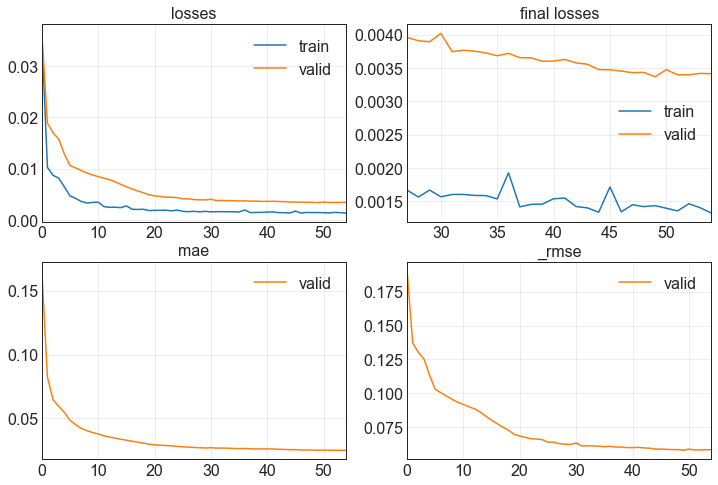

186.63890051841736                                                                                                     
[0.001320532406680286, 0.003412824822589755, 0.02507917955517769, 0.05841938406229019]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 88%|████████████████████████████████████▉     | 88/100 [1:35:17<17:38, 88.24s/trial, best loss: 0.0028997096233069897]

No improvement since epoch 37: early stopping                                                                          
 88%|████████████████████████████████████▉     | 88/100 [1:36:06<17:38, 88.24s/trial, best loss: 0.0028997096233069897]

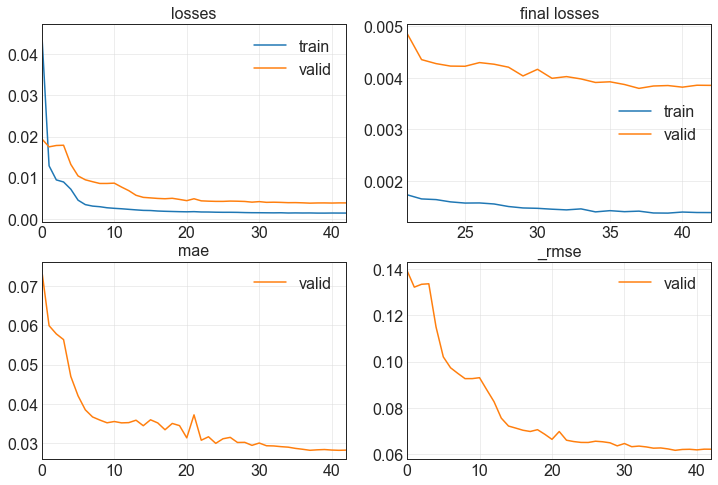

49.14561128616333                                                                                                      
[0.0013844507047906518, 0.0038551753386855125, 0.028245223686099052, 0.062090057879686356]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 89%|█████████████████████████████████████▍    | 89/100 [1:36:08<14:06, 76.96s/trial, best loss: 0.0028997096233069897]

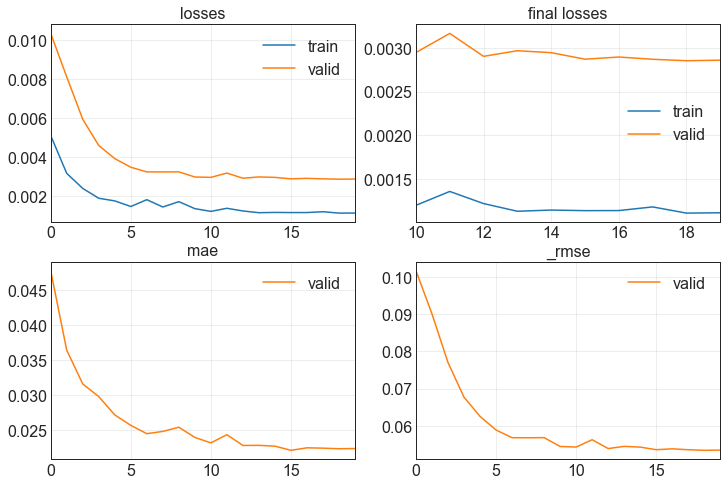

68.92015933990479                                                                                                      
[0.001113549922592938, 0.0028599516954272985, 0.022347506135702133, 0.053478509187698364]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 90%|█████████████████████████████████████▊    | 90/100 [1:37:18<12:29, 74.98s/trial, best loss: 0.0028599516954272985]

No improvement since epoch 2: early stopping                                                                           
 90%|█████████████████████████████████████▊    | 90/100 [1:37:41<12:29, 74.98s/trial, best loss: 0.0028599516954272985]

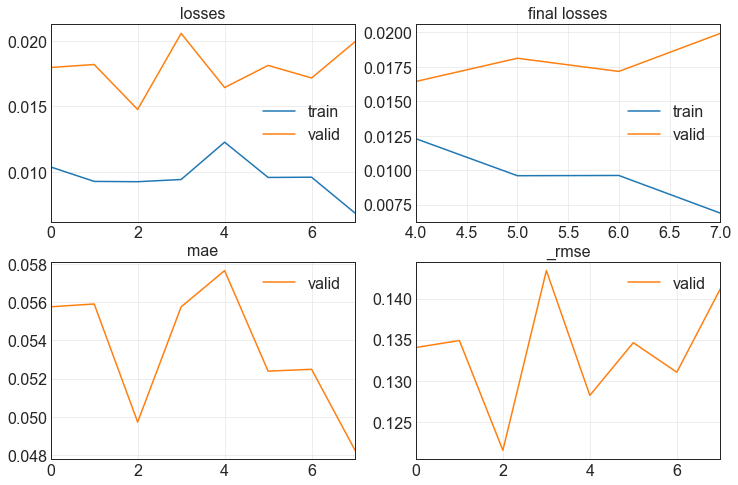

23.717456340789795                                                                                                     
[0.006882394663989544, 0.019929420202970505, 0.048249538987874985, 0.14117160439491272]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 91%|██████████████████████████████████████▏   | 91/100 [1:37:43<09:00, 60.04s/trial, best loss: 0.0028599516954272985]

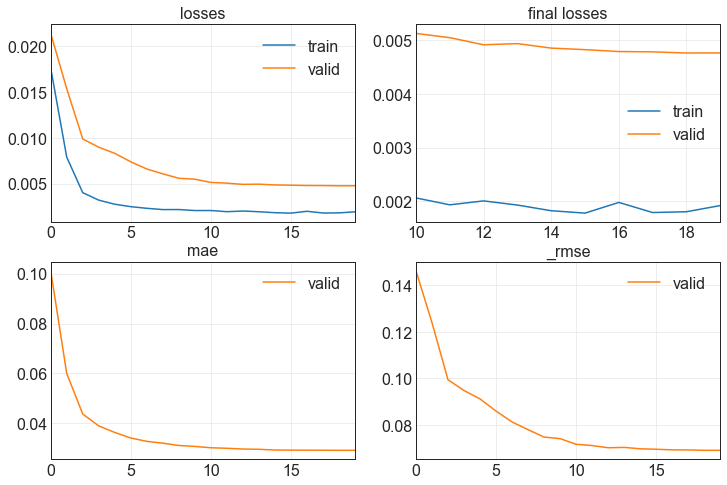

68.57639789581299                                                                                                      
[0.0019208122976124287, 0.0047656032256782055, 0.029114533215761185, 0.06903334707021713]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 92%|██████████████████████████████████████▋   | 92/100 [1:38:53<08:24, 63.04s/trial, best loss: 0.0028599516954272985]

No improvement since epoch 37: early stopping                                                                          
 92%|██████████████████████████████████████▋   | 92/100 [1:39:33<08:24, 63.04s/trial, best loss: 0.0028599516954272985]

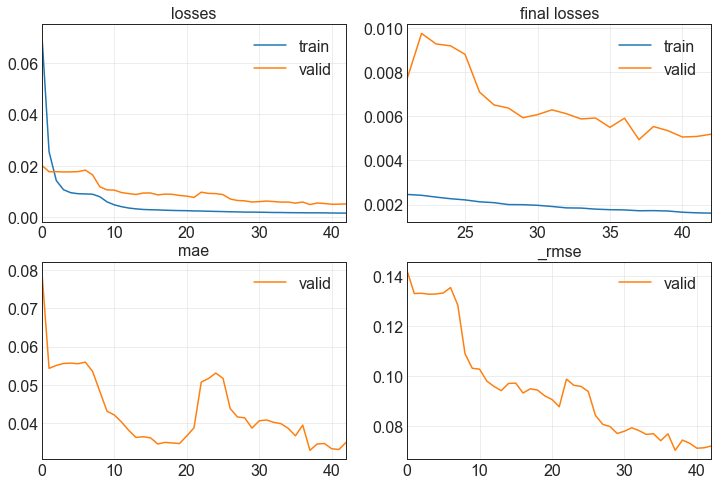

40.34204030036926                                                                                                      
[0.001617996720597148, 0.005191049072891474, 0.03500104323029518, 0.07204894721508026]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 93%|███████████████████████████████████████   | 93/100 [1:39:35<06:36, 56.68s/trial, best loss: 0.0028599516954272985]

No improvement since epoch 6: early stopping                                                                           
 93%|███████████████████████████████████████   | 93/100 [1:40:50<06:36, 56.68s/trial, best loss: 0.0028599516954272985]

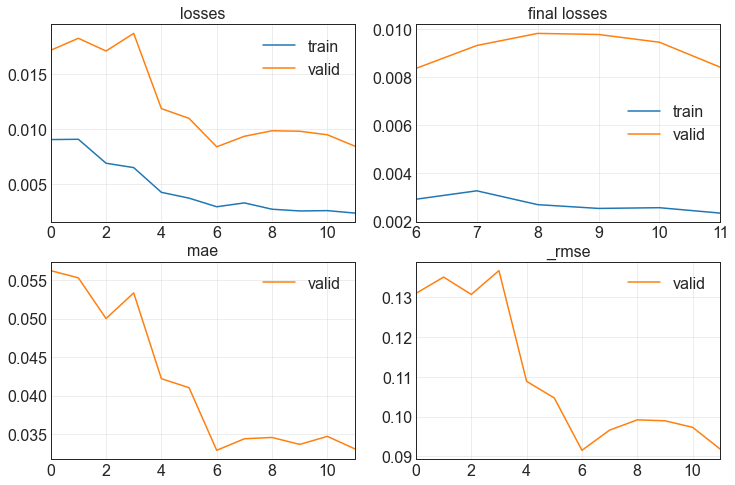

75.70116853713989                                                                                                      
[0.0023507140576839447, 0.00842564832419157, 0.0330704003572464, 0.09179133176803589]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 94%|███████████████████████████████████████▍  | 94/100 [1:40:52<06:17, 62.84s/trial, best loss: 0.0028599516954272985]

No improvement since epoch 18: early stopping                                                                          
 94%|███████████████████████████████████████▍  | 94/100 [1:41:56<06:17, 62.84s/trial, best loss: 0.0028599516954272985]

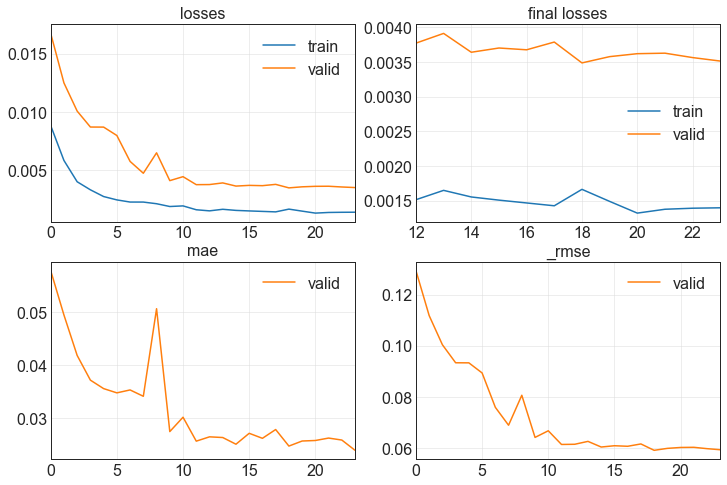

64.59755539894104                                                                                                      
[0.001394983846694231, 0.0035110751632601023, 0.023877430707216263, 0.05925433337688446]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 95%|███████████████████████████████████████▉  | 95/100 [1:41:58<05:19, 63.81s/trial, best loss: 0.0028599516954272985]

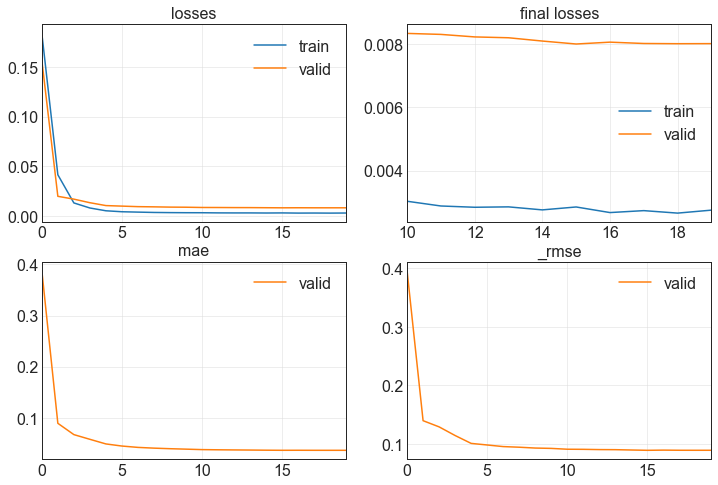

18.417405128479004                                                                                                     
[0.0027534698601812124, 0.008010707795619965, 0.036298442631959915, 0.08950255811214447]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 96%|████████████████████████████████████████▎ | 96/100 [1:42:18<03:22, 50.62s/trial, best loss: 0.0028599516954272985]

No improvement since epoch 7: early stopping                                                                           
 96%|████████████████████████████████████████▎ | 96/100 [1:42:51<03:22, 50.62s/trial, best loss: 0.0028599516954272985]

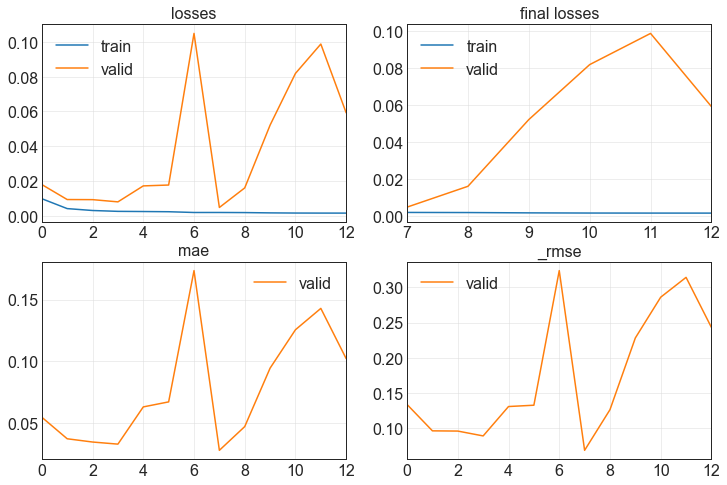

33.857868671417236                                                                                                     
[0.0015096409479156137, 0.05920124053955078, 0.10225075483322144, 0.2433130443096161]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 97%|████████████████████████████████████████▋ | 97/100 [1:42:53<02:18, 46.03s/trial, best loss: 0.0028599516954272985]

No improvement since epoch 5: early stopping                                                                           
 97%|████████████████████████████████████████▋ | 97/100 [1:44:26<02:18, 46.03s/trial, best loss: 0.0028599516954272985]

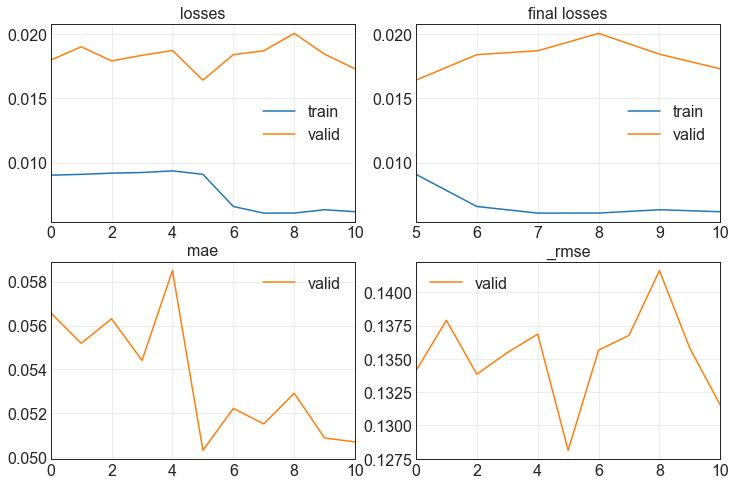

92.9155809879303                                                                                                       
[0.006181206088513136, 0.017298704013228416, 0.05069045349955559, 0.13152453303337097]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 98%|█████████████████████████████████████████▏| 98/100 [1:44:28<02:01, 60.52s/trial, best loss: 0.0028599516954272985]

No improvement since epoch 25: early stopping                                                                          
 98%|█████████████████████████████████████████▏| 98/100 [1:46:13<02:01, 60.52s/trial, best loss: 0.0028599516954272985]

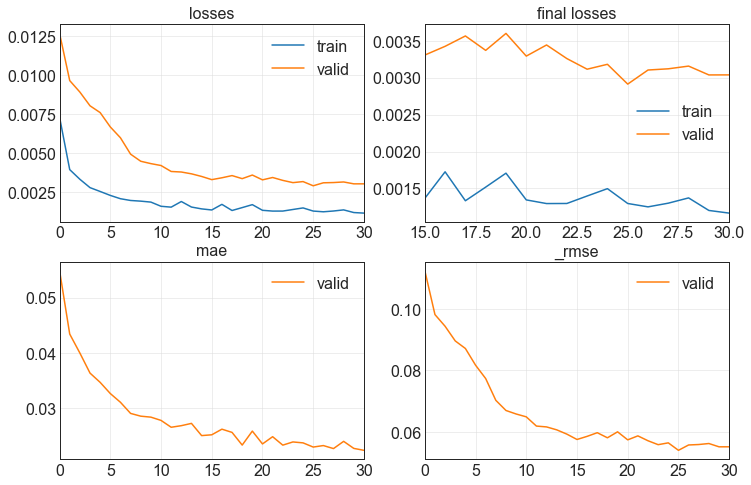

105.701975107193                                                                                                       
[0.001165613066405058, 0.0030377907678484917, 0.02237439714372158, 0.05511615797877312]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 20, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}
GRU                                                                                                                    
 99%|█████████████████████████████████████████▌| 99/100 [1:46:15<01:14, 74.51s/trial, best loss: 0.0028599516954272985]

No improvement since epoch 13: early stopping                                                                          
 99%|█████████████████████████████████████████▌| 99/100 [1:46:23<01:14, 74.51s/trial, best loss: 0.0028599516954272985]

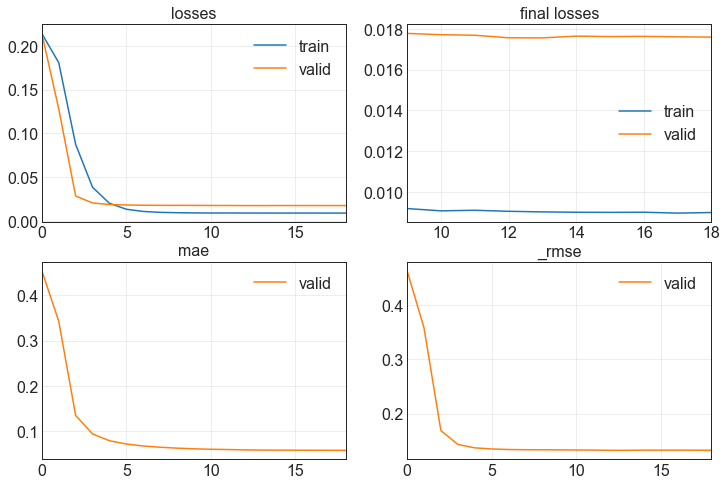

8.604203462600708                                                                                                      
[0.009001282043755054, 0.01759175769984722, 0.057923175394535065, 0.13263392448425293]                                 
100%|█████████████████████████████████████████| 100/100 [1:46:24<00:00, 63.84s/trial, best loss: 0.0028599516954272985]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002E8F89A5438>, 'patience': 5}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(8606, 529, 10)

In [62]:
y.shape

(8606, 529)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = GRU
k = {
    'n_layers': params['n_layers'],
    'hidden_size': params['hidden_size'],
    'bidirectional': params['bidirectional']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

GRU


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): GRU(
    (rnn): GRU(529, 100, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=200, out_features=529, bias=True)
  )
  (1): Sigmoid()
)

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

484,929 total parameters.
484,929 training parameters.


Training the model:

No improvement since epoch 8: early stopping


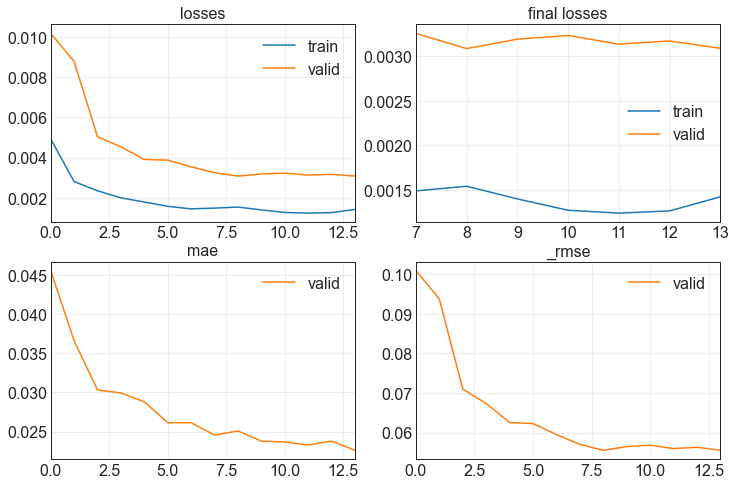

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

2153


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0035, 0.0414, 0.0154,  ..., 0.0041, 0.0041, 0.0024],
         [0.0035, 0.0371, 0.0140,  ..., 0.0040, 0.0041, 0.0024],
         [0.0036, 0.0380, 0.0152,  ..., 0.0041, 0.0042, 0.0024],
         ...,
         [0.0033, 0.0237, 0.0271,  ..., 0.0036, 0.0041, 0.0028],
         [0.0033, 0.0237, 0.0312,  ..., 0.0034, 0.0041, 0.0027],
         [0.0035, 0.0241, 0.0304,  ..., 0.0037, 0.0043, 0.0028]]),
 tensor([[0.0000e+00, 4.2537e-04, 9.6929e-04,  ..., 4.5983e-04, 1.2533e-04,
          0.0000e+00],
         [0.0000e+00, 1.6241e-04, 3.8517e-04,  ..., 5.4193e-04, 8.0880e-05,
          0.0000e+00],
         [0.0000e+00, 2.2912e-04, 1.9301e-03,  ..., 4.0765e-04, 1.9965e-04,
          0.0000e+00],
         ...,
         [0.0000e+00, 4.7334e-03, 0.0000e+00,  ..., 1.2775e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 6.2943e-03, 0.0000e+00,  ..., 1.1132e-03, 2.1495e-04,
          0.0000e+00],
         [0.0000e+00, 1.3714e-02, 0.0000e+00,  ..., 1.7625e-04, 0.0000e+00,
         

In [73]:
test_targets.shape

torch.Size([2153, 529])

In [74]:
test_preds.shape

torch.Size([2153, 529])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(2153, 1, 529)

In [78]:
y_pred.shape

(2153, 1, 529)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(2153, 1, 529)

In [83]:
y_pred.shape

(2153, 1, 529)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  48.063724994659424
Test time (in seconds):  0.5499997138977051


In [92]:
print('Training time (in seconds) per epoch: ', 48.063724994659424 / 14)

Training time (in seconds) per epoch:  3.4331232139042447


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  13.87381510576644
MAE:  4.934539425988673


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

GRU_TM-minmax_RMSE-10-1-step-1.pdf
GRU_TM-minmax_MAE-10-1-step-1.pdf


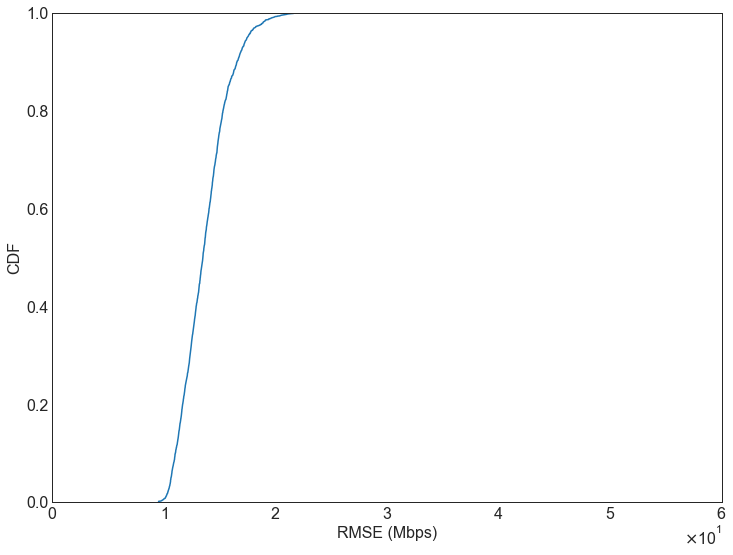

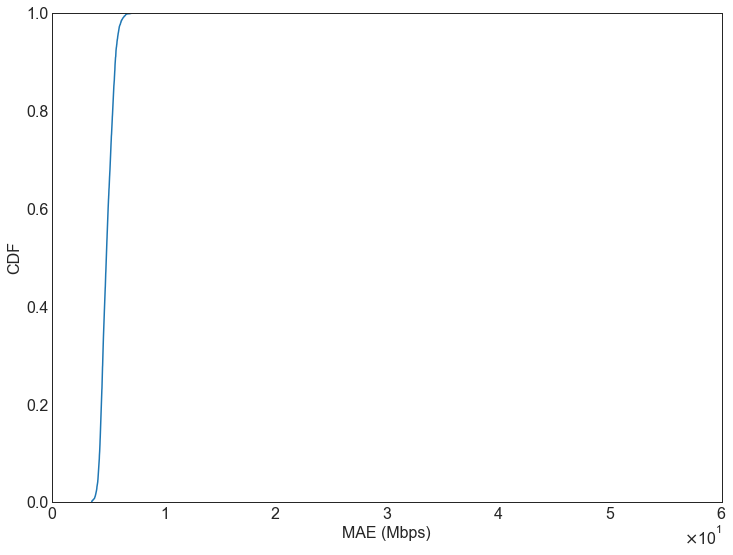

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)